In [1]:
import sys
import pickle
import pyccl as ccl
sys.path.insert(0,'./')
# from importlib import reload

In [128]:
from astropy.cosmology import Planck15 as cosmo
cosmo_h=cosmo.clone(H0=100)

In [170]:
import pyccl as ccl
print(ccl.__version__)
cosmo_params={'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'As': 2.12e-09,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}
mnu=cosmo_h.m_nu*0
cosmo_h=cosmo.clone(H0=100,m_nu=mnu)

0.3.5


In [131]:
from cov_3X2 import *
from fisher import *

In [132]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [133]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [134]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [135]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [136]:
def readclxipm(filename):
    nz_bins=4
    na=20
    nz=np.int(nz_bins*(nz_bins+1.)/2.)
    print(nz)
    n_theta=ndesa=20
    tp_fits = fits.open(filename)[1].data #fitsio.FITS(filename)
    #xip = tp_fits['xip']
    #theta = xip['ang'][:ndesa]
    #thc = np.delete(theta,range(ndesa-na))

    ccl = tp_fits#[1]
    ccl_xip=ccl[:2*ndesa*nz,:2*ndesa*nz] #factor of 2 for xi_-
    #print ccl_xip[399,390:399]
    cov=np.zeros((2*nz*na,2*nz*na))
    for z1 in range(2*nz):
        for a1 in range(na):
            i1 = a1+z1*na
        ## The index in the original matrix is skewed because that matrix contains
        ## angles that have been cut. So 
            i1ccl = (a1+ndesa-na) + z1*ndesa
            for z2 in range(2*nz):
                for a2 in range(na):
                    i2 = a2 + z2*na
                ## The index in the original matrix is skewed because that matrix contains
                ## angles that have been cut. So 
                    i2ccl = (a2+ndesa-na) + z2*ndesa
                    cov[i1,i2]=ccl_xip[i1ccl,i2ccl]
    return cov

In [137]:
fname='/home/deep/data/KiDS-450/'
Kids_dat=np.genfromtxt(fname+'DATA_VECTOR/KiDS-450_xi_pm_tomographic_data_vector.dat',names=True)

In [138]:
cols=['z1_i','z1_j','s1','th1','z2_i','z2_j','s2','th2','G','T','SSV']
Kids_cov=np.genfromtxt(fname+'COV_MAT/Cov_mat_all_scales.txt',names=cols)

In [139]:
nz_bins=4
nth_bins=9
z_indxs=[j for j in itertools.combinations_with_replacement(np.arange(nz_bins)+1,2)]
corr_indxs=[j for j in itertools.combinations_with_replacement(np.arange(2),2)]
th=np.unique(Kids_cov['th1'])
ndat=len(th)*2*len(z_indxs)
kids_cov=np.zeros((ndat,ndat))
# th_indxs=[j for j in itertools.combinations_with_replacement(np.arange(nth_bins),2)]

In [140]:
for ci in np.arange(2):
    for cj in np.arange(ci,2):
        for zi in np.arange(len(z_indxs)):
            for zj in np.arange(zi,len(z_indxs)):
                for thi in np.arange(nth_bins):
                    for thj in np.arange(thi,nth_bins):
                        ci_indx=ndat/2*ci
                        cj_indx=ndat/2*cj
                        zi_indx=nth_bins*zi
                        zj_indx=nth_bins*zj
                        
                        x=Kids_cov['z1_i']==z_indxs[zi][0]
                        x*=Kids_cov['z1_j']==z_indxs[zi][1]
                        x*=Kids_cov['s1']==ci
                        x*=Kids_cov['z2_i']==z_indxs[zj][0]
                        x*=Kids_cov['z2_j']==z_indxs[zj][1]
                        x*=Kids_cov['s2']==cj
                        x*=Kids_cov['th1']==th[thi]
                        x*=Kids_cov['th2']==th[thj]
                        for (cii,cjj) in [(ci_indx,cj_indx),(cj_indx,ci_indx)]:
                            for (zii,zjj) in [(zi_indx,zj_indx),(zj_indx,zi_indx)]:
                                for (thii,thjj) in [(thi,thj),(thj,thi)]:
                                    idx=int(cii+zii+thii)
                                    jdx=int(cjj+zjj+thjj)

                                    kids_cov[idx,jdx]=Kids_cov[x]['G']

In [141]:
f_sky=450./(4*np.pi/d2r**2)
# f_sky=4182./(4*np.pi/d2r**2)

In [142]:
#Setup redshift bins
zmin=0
zmax=3

nbins=4  # Number of tomographic bins
zs_bins=Kids_bins()

ns0=np.sum(zs_bins['nz'])

In [143]:
th=np.unique(Kids_cov['th1'])
logth=np.log10(th)
dlogth=np.gradient(np.log10(th))
logth_min=logth-0.5*dlogth
logth_max=logth+0.5*dlogth
print(10**logth_min,10**logth_max)


[  0.50000003   1.01777927   2.07174845   4.21716285   8.58428118
  17.4738001   35.56892597  72.40263973 147.37972733] [  1.01777918   2.07174862   4.21716325   8.58427951  17.47380221
  35.56892845  72.40261864 147.37975633 299.999832  ]


In [186]:
do_xi=True
bin_xi=True
do_cov=True
bin_cl=False
th_min=.5/60
th_max=300./60
n_th_bins=9
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins*40)
thb=0.5*(th_bins[1:]+th_bins[:-1])

In [145]:
#Hankel Transform setup
l_max=1e4
l_min=2
l0=np.arange(l_min,l_max)
prune_theta=1
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*3, 'theta_max':th_max*d2r,#th_min increased for speed
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [146]:
bin_xi=True
l_bins=None


In [147]:
use_window=False
do_sample_variance=True
SSV_cov=False
tidal_SSV=False
sigma_gamma=0.29 #/np.sqrt(2)

In [148]:
#use redshift bins from power spectrum part
XI_H =cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,zg_bins=None,l_bins=l_bins,do_sample_variance=do_sample_variance,use_window=use_window,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,sigma_gamma=sigma_gamma)#ns=np.inf)
# XI_H2 = lensing_lensing(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs2,
#                bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

05:09:05 WARNING:cross covariance not implemented with Hankel Transform. m1_m2s: [(2, 2), (2, -2)]
05:09:05 INFO:pruning theta, log_space:True n_f:1
05:09:05 INFO:pruned theta:136
05:09:05 INFO:nr:136
05:09:07 INFO:changed l_max to 17391.199799883852 to cover theta_min. j_nu=4
05:09:07 INFO:pruning theta, log_space:True n_f:1
05:09:07 INFO:pruned theta:221
05:09:07 INFO:nr:220


In [149]:
l_bins=np.logspace(1,3,40)

In [150]:
# Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': np.arange(2,l_max*2,dtype='int'),'theta': th*d2r,'m1_m2':[(2,2),(2,-2)]}
# %time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,do_sample_variance=do_sample_variance,use_window=use_window,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,sigma_gamma=sigma_gamma,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [152]:
corr=('shear','shear')

In [172]:
%time xiHG=XI_H.xi_tomo(cosmo_params=cosmo_params,cosmo_h=cosmo_h)
%time xiWG_L=XI_W_L.xi_tomo(cosmo_params=cosmo_params,cosmo_h=cosmo_h)

[('shear', 'shear')]
CPU times: user 75 ms, sys: 20 µs, total: 75.1 ms
Wall time: 71.8 ms
[('shear', 'shear')]
CPU times: user 45.4 ms, sys: 6.62 ms, total: 52 ms
Wall time: 51.2 ms


/usr/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [175]:
%time xiH=xiHG['stack'].compute()
%time xiW_L=xiWG_L['stack'].compute()

20 9 2
CPU times: user 24min 5s, sys: 7.96 s, total: 24min 13s
Wall time: 1min 40s


In [155]:
f=1
# cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
# print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

23.71875765532224


./cov_utils.py:59: RuntimeWarning: invalid value encountered in true_divide
  return cov/np.sqrt(np.outer(diag,diag))
/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


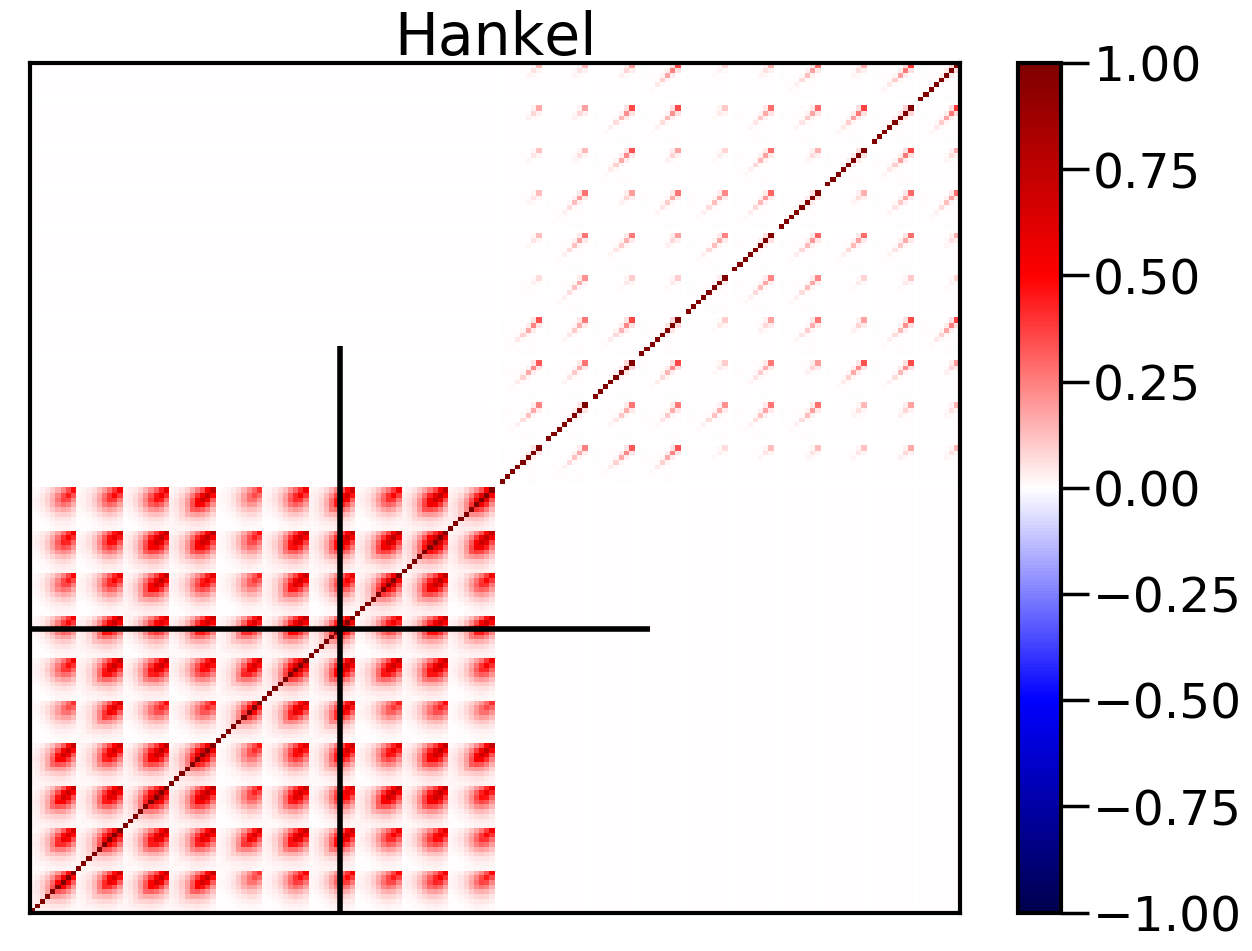

In [156]:
cc=XI_H.cov_utils
corrH=cc.corr_matrix(xiH['cov'])
pcolor(corrH,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Hankel')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


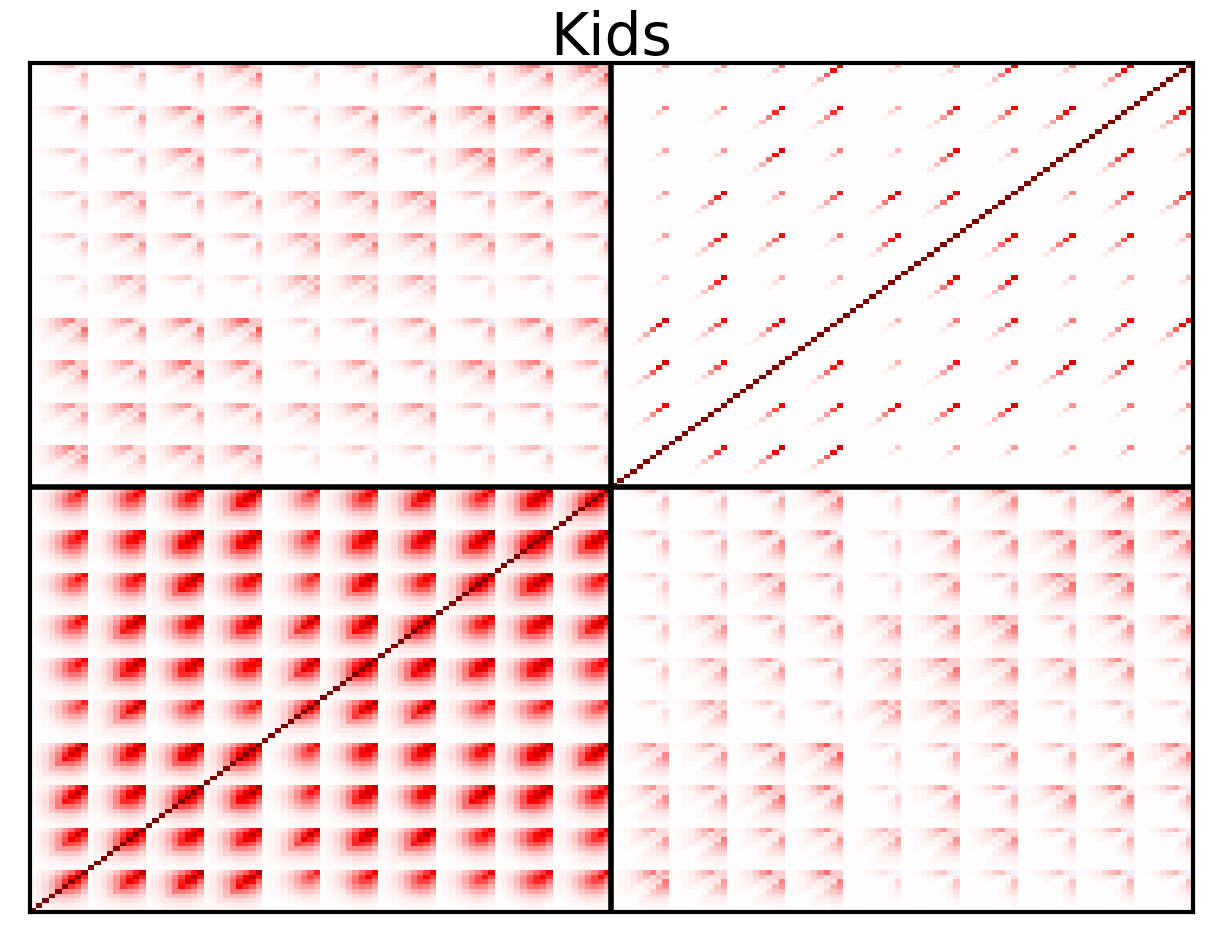

In [157]:
corr_kids=cc.corr_matrix(kids_cov)
pcolor(corr_kids,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
vlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
xticks([])
yticks([])
title('Kids')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


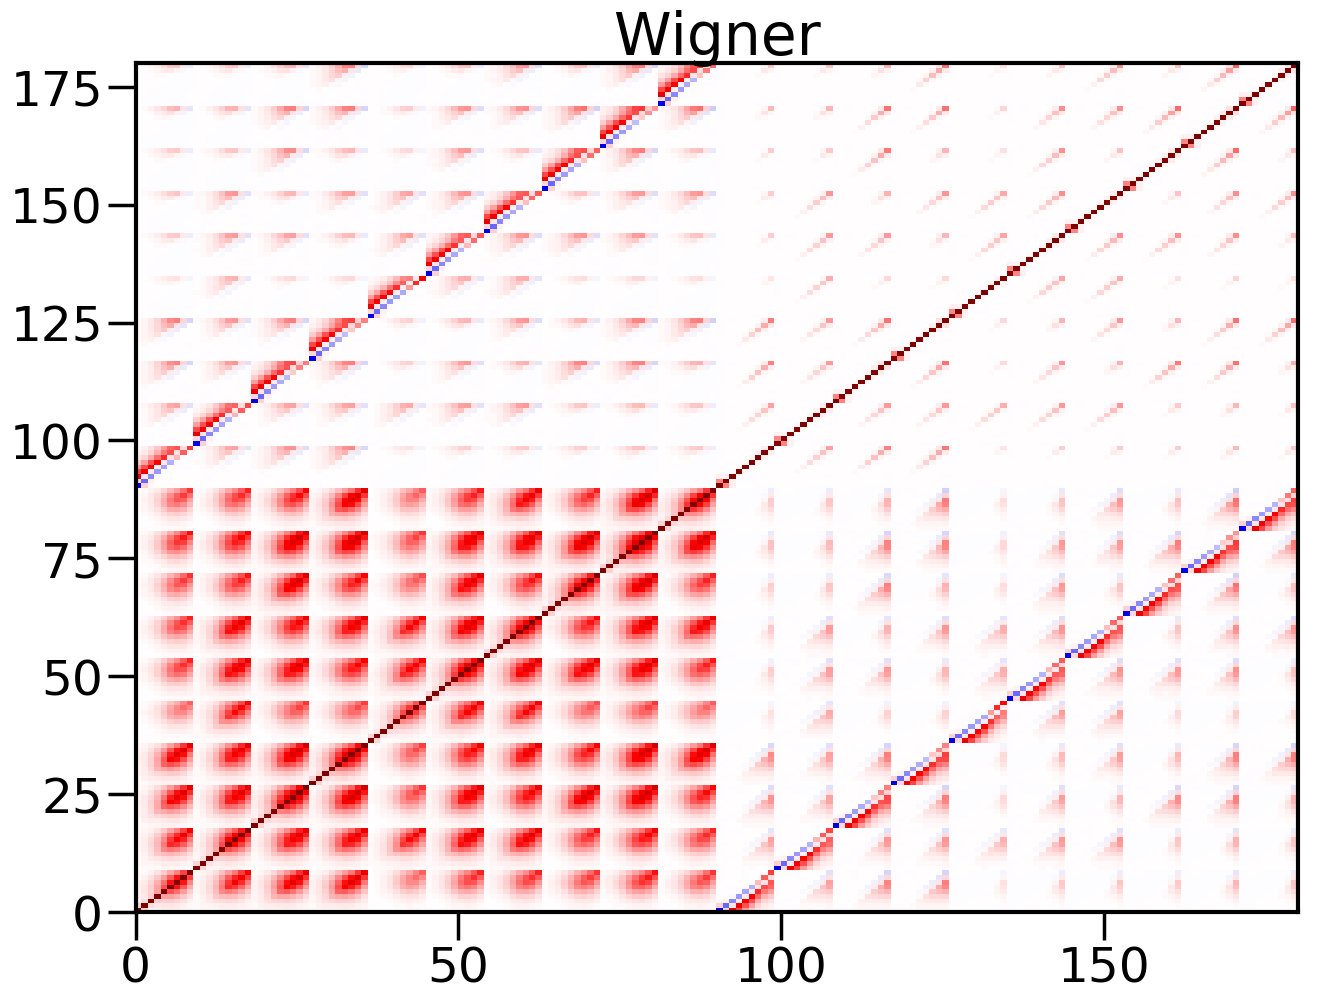

In [158]:
cc=XI_W_L.cov_utils
corrWL=cc.corr_matrix(xiW_L['cov'])
pcolor(corrWL,vmin=-1,vmax=1,cmap='seismic')
title('Wigner')
show()

In [176]:
cosmo_params={'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'As': 2.12e-09,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}

ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


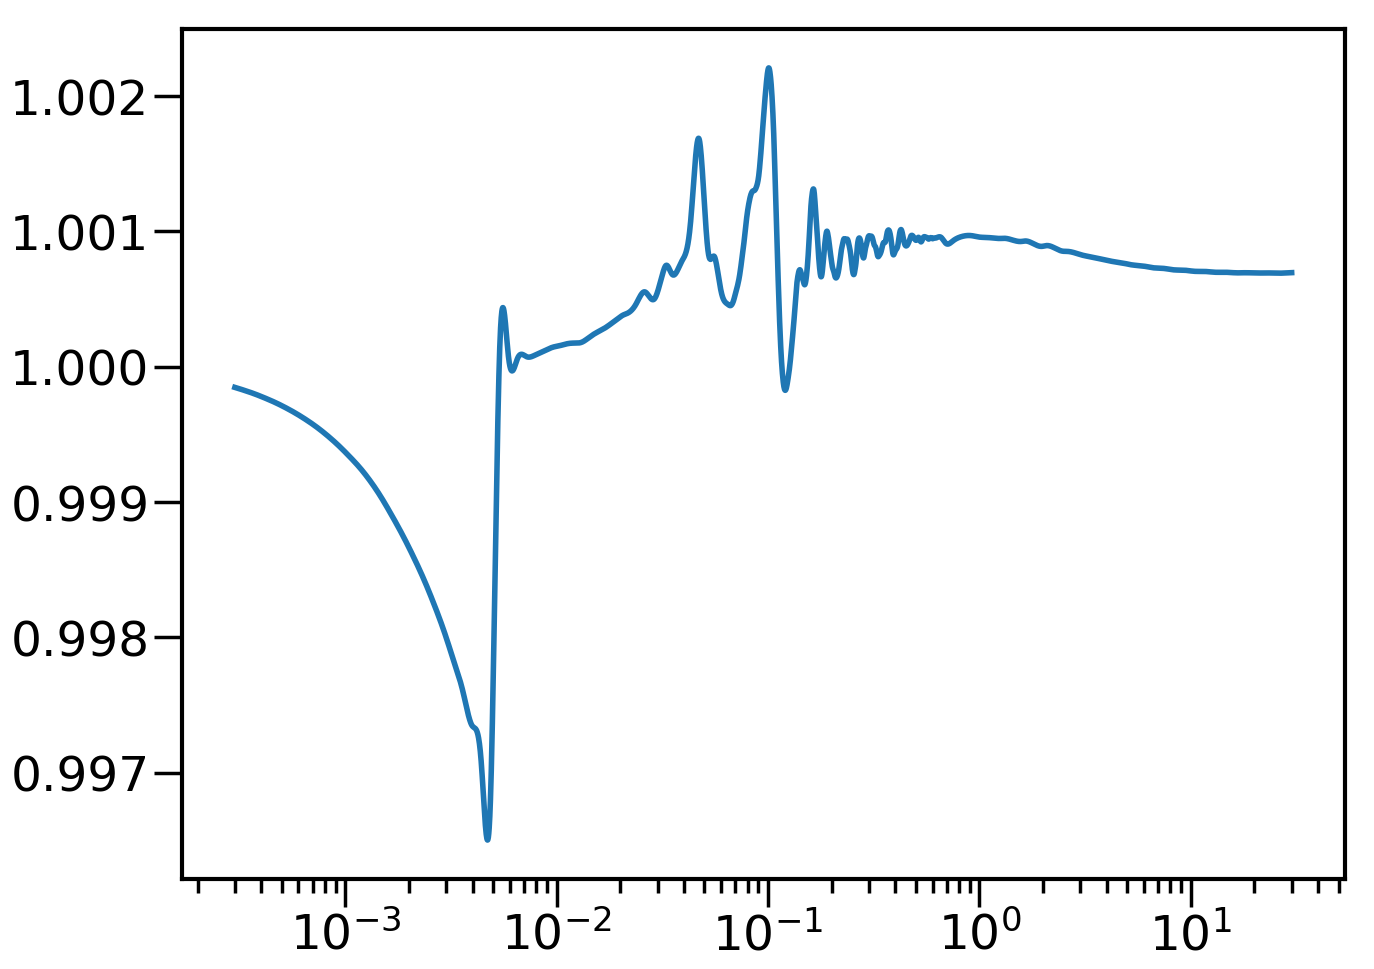

In [161]:
k = XI_W_L.Ang_PS.PS.kh
a = 1. # Scale factor
pk_nl = ccl.nonlin_matter_power(ccl_cosmo, k*cosmo_params['h'], a)
pk2,k2=XI_W_L.Ang_PS.PS.camb_pk(z=array([0]),cosmo_params=cosmo_params)
plot(k,pk_nl*cosmo_params['h']**3/pk2[0])
xscale('log')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


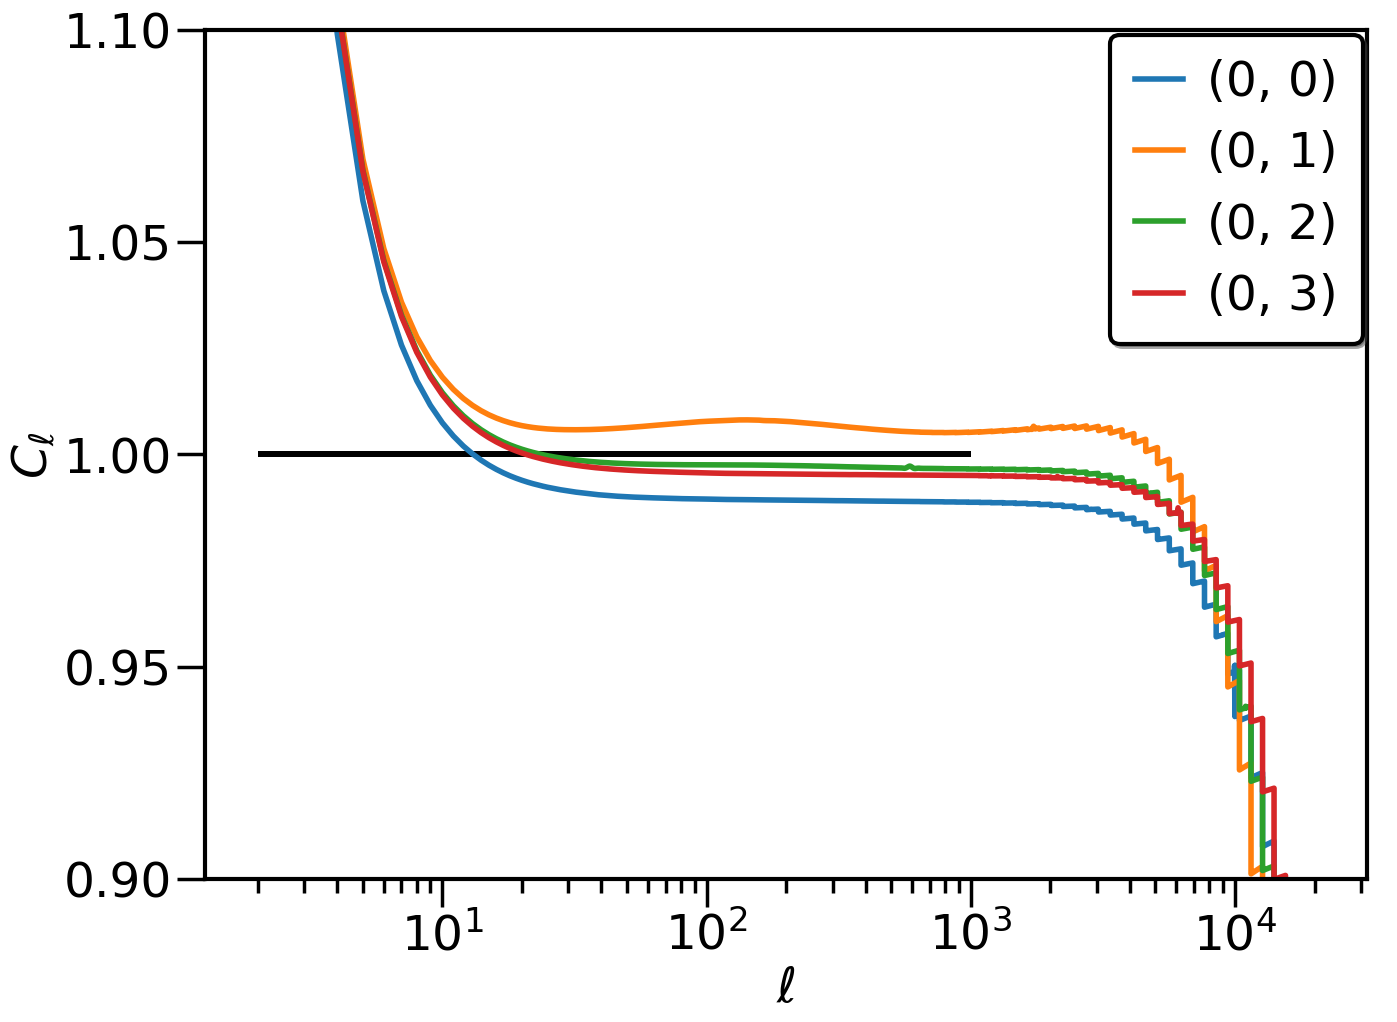

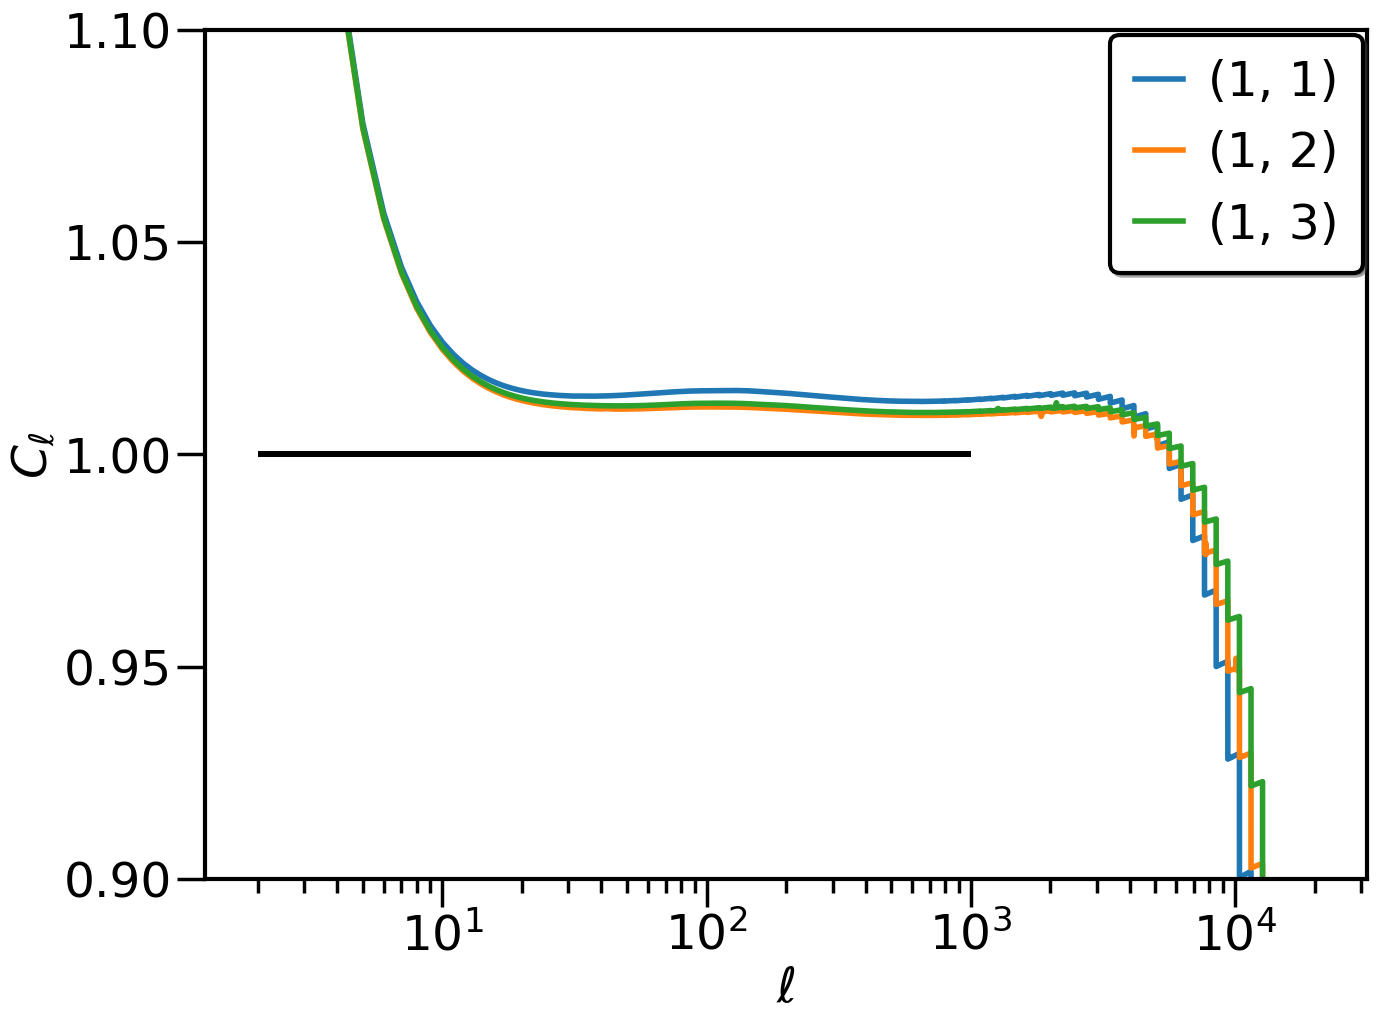

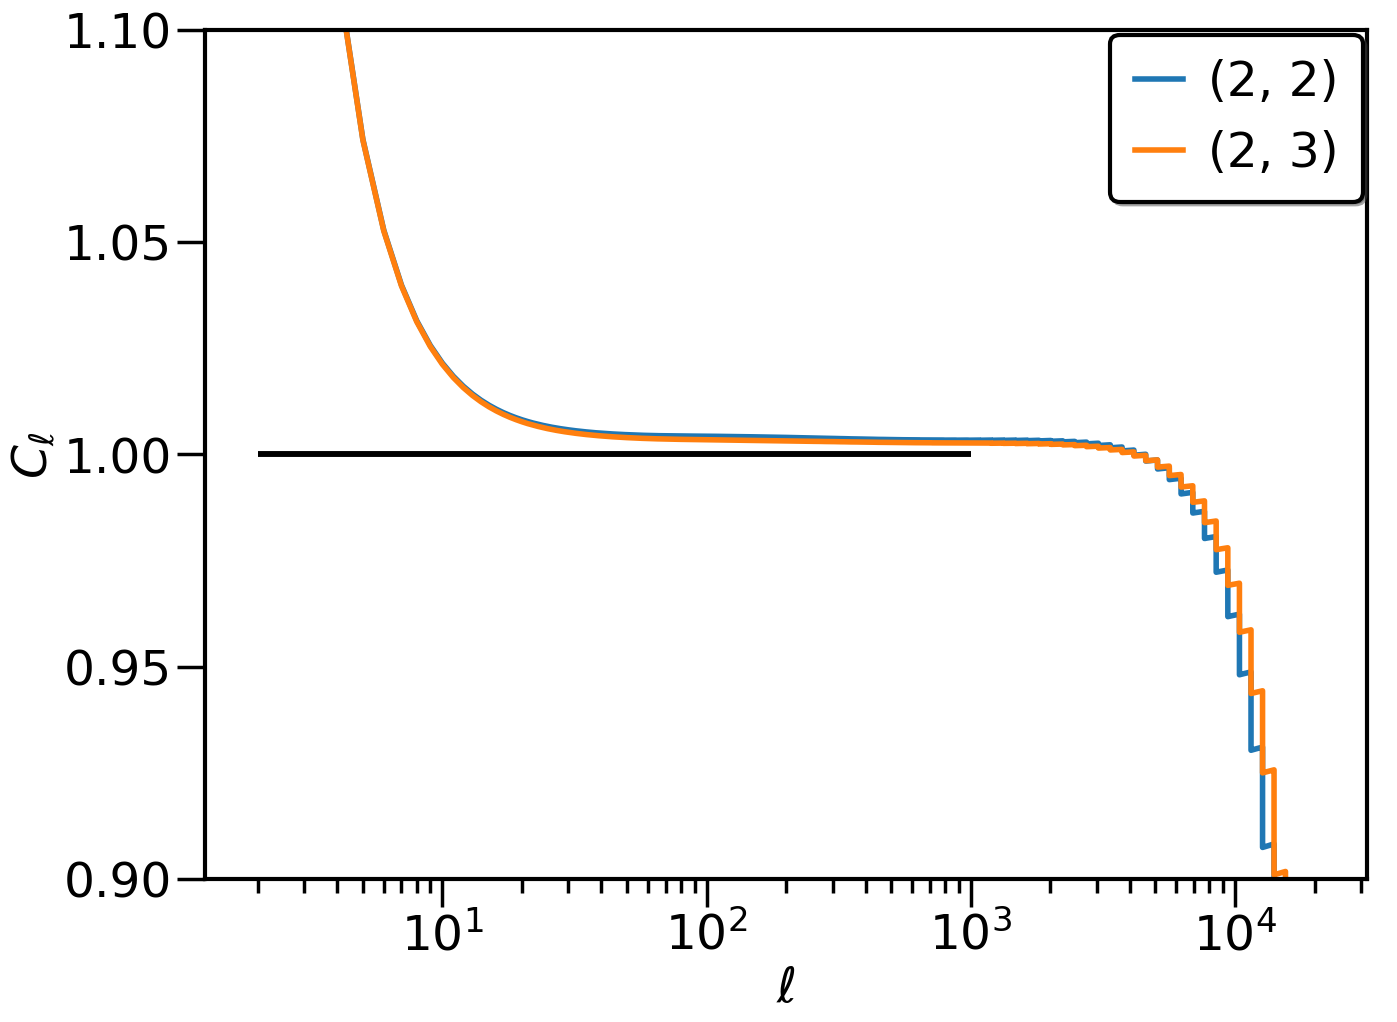

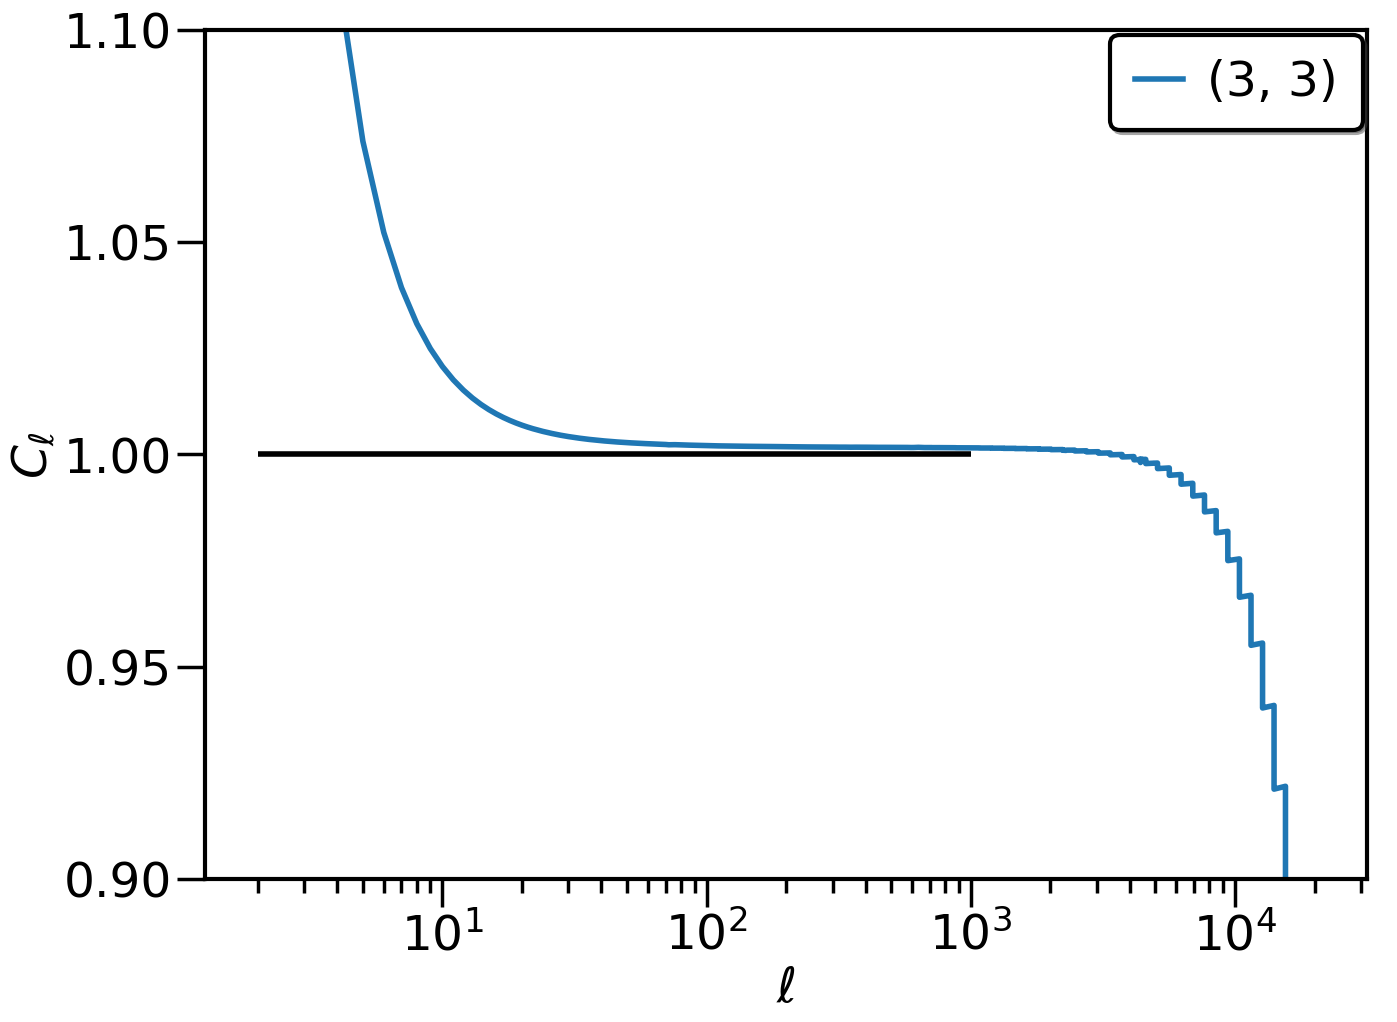

In [178]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
#         errorbar(thb,xiHG['xi'][corr][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
#         plot(XI_W_L.l,xiWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
#         plot(XI_W_L.l,clWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
#         xi_plus = ccl.correlation(ccl_cosmo, ell, cls, th,corr_type='L+', method='FFTLog')
#         plot(XI_W_L.l,cls)
        plot(XI_W_L.l,xiWG_L['cl'][corr][(i,j)].compute()/cls,label=(i,j))
        xscale('log')
#         yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
        hlines(1,2,1000)
        legend()
        ylim(0.9,1.1)
    show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


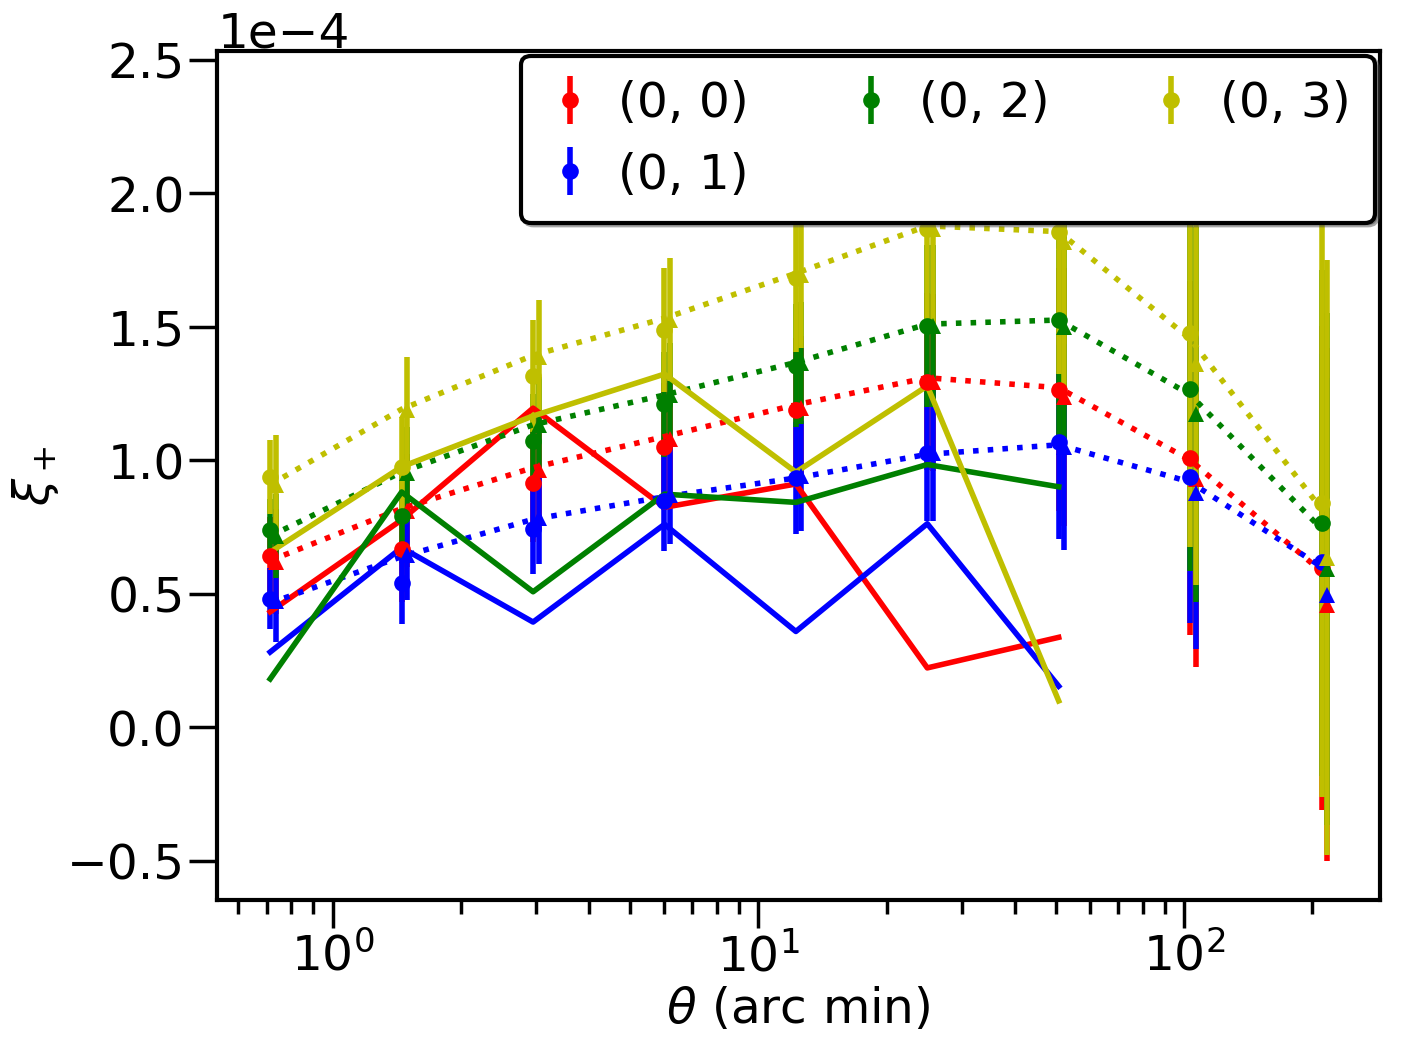

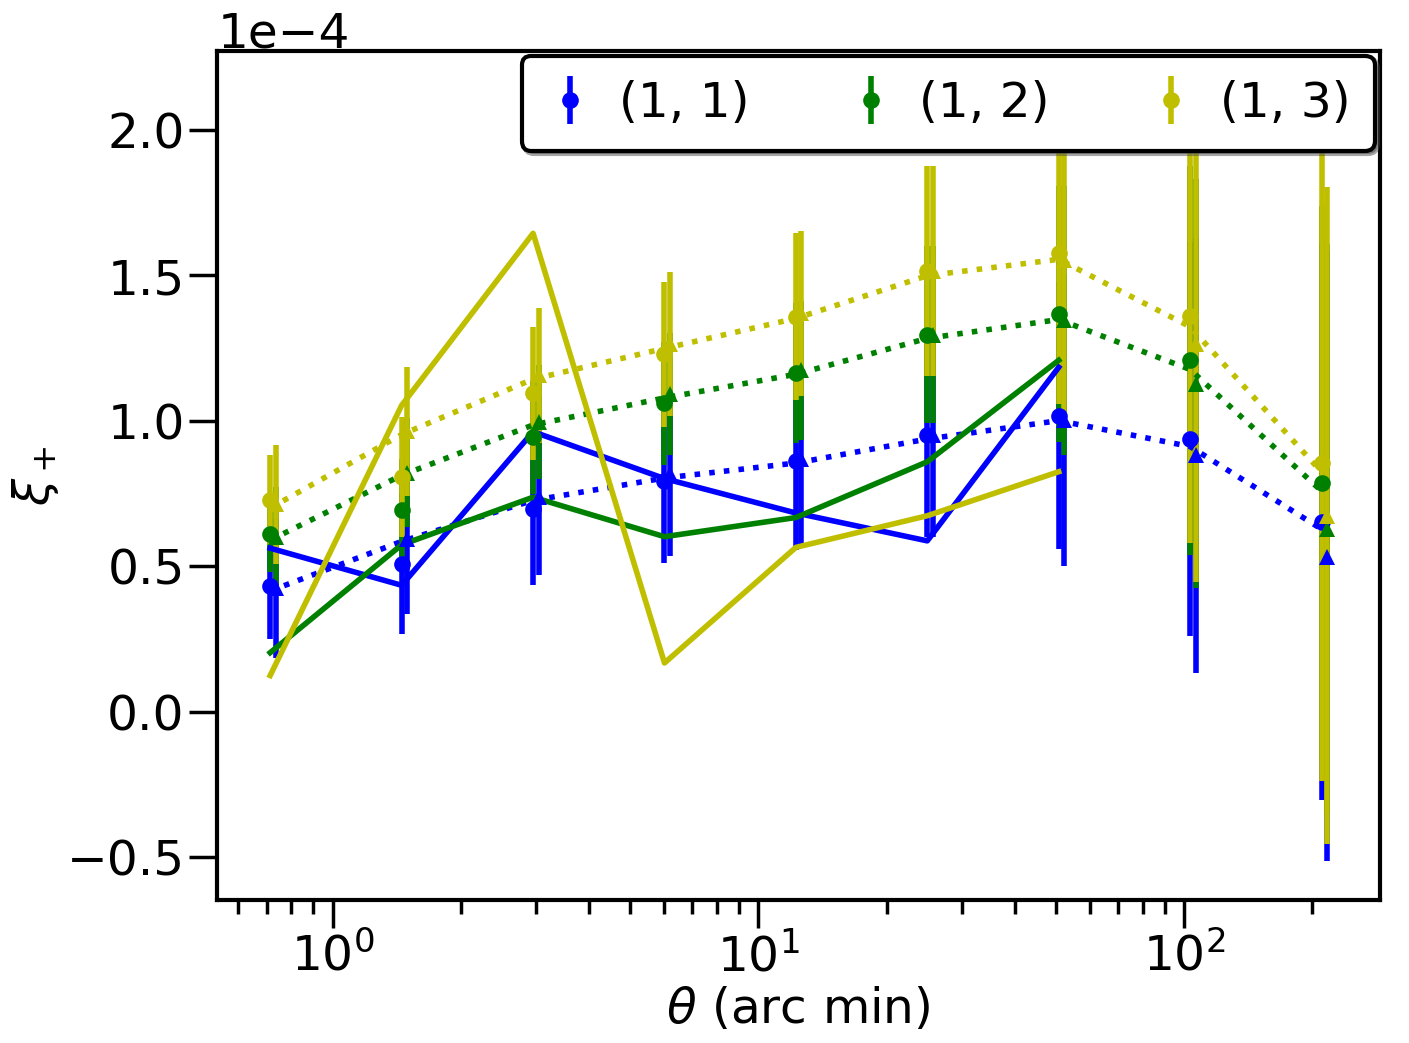

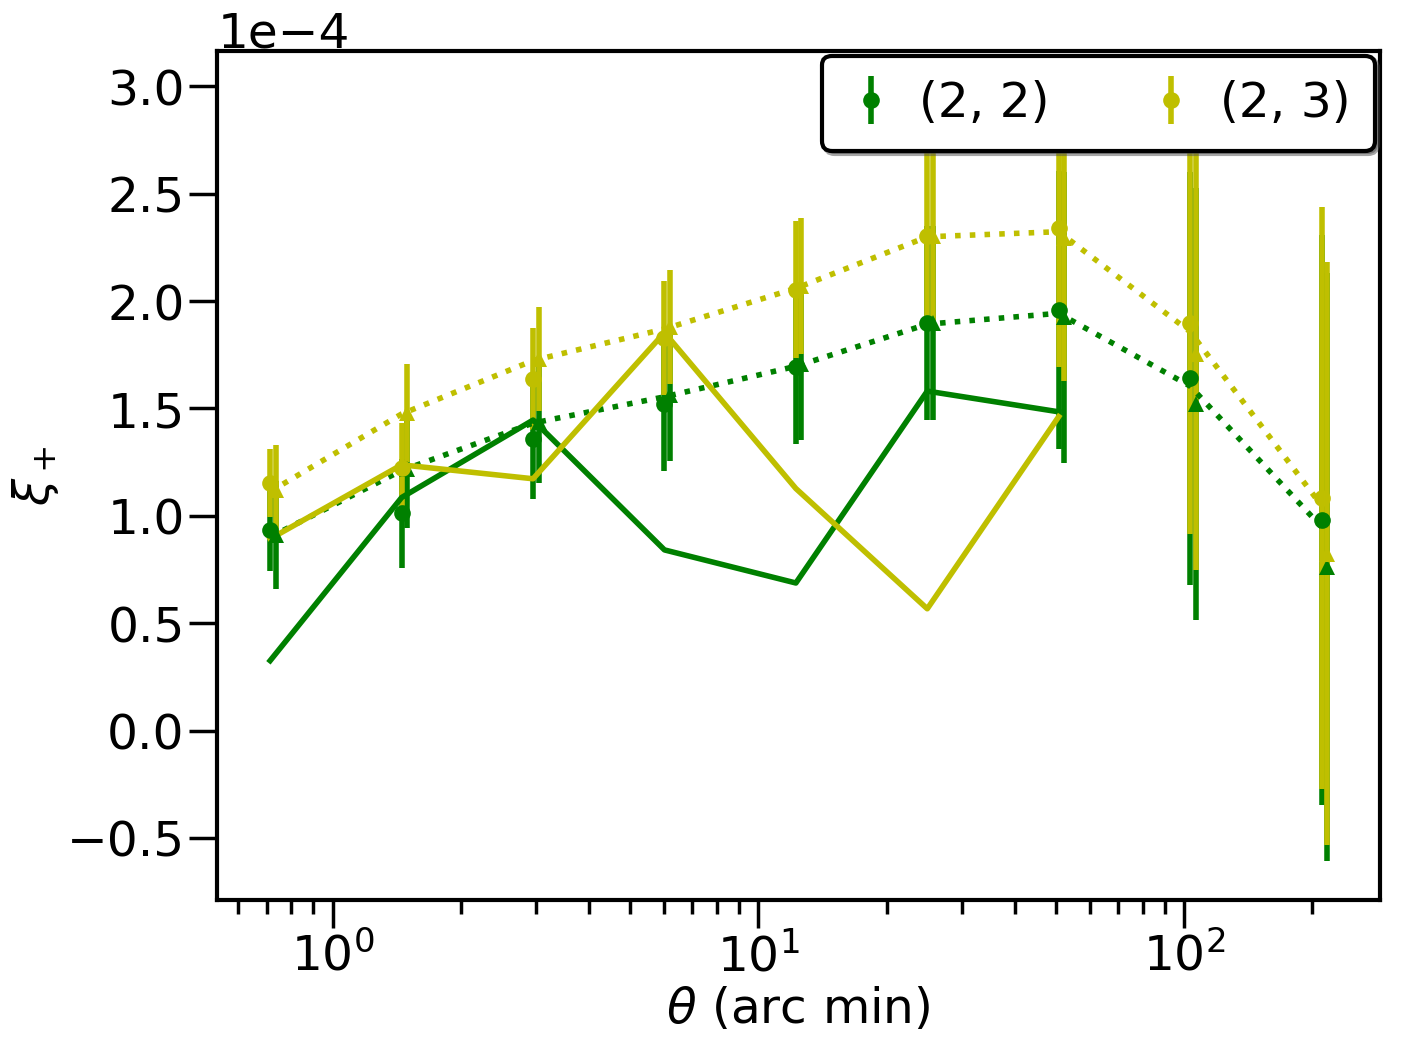

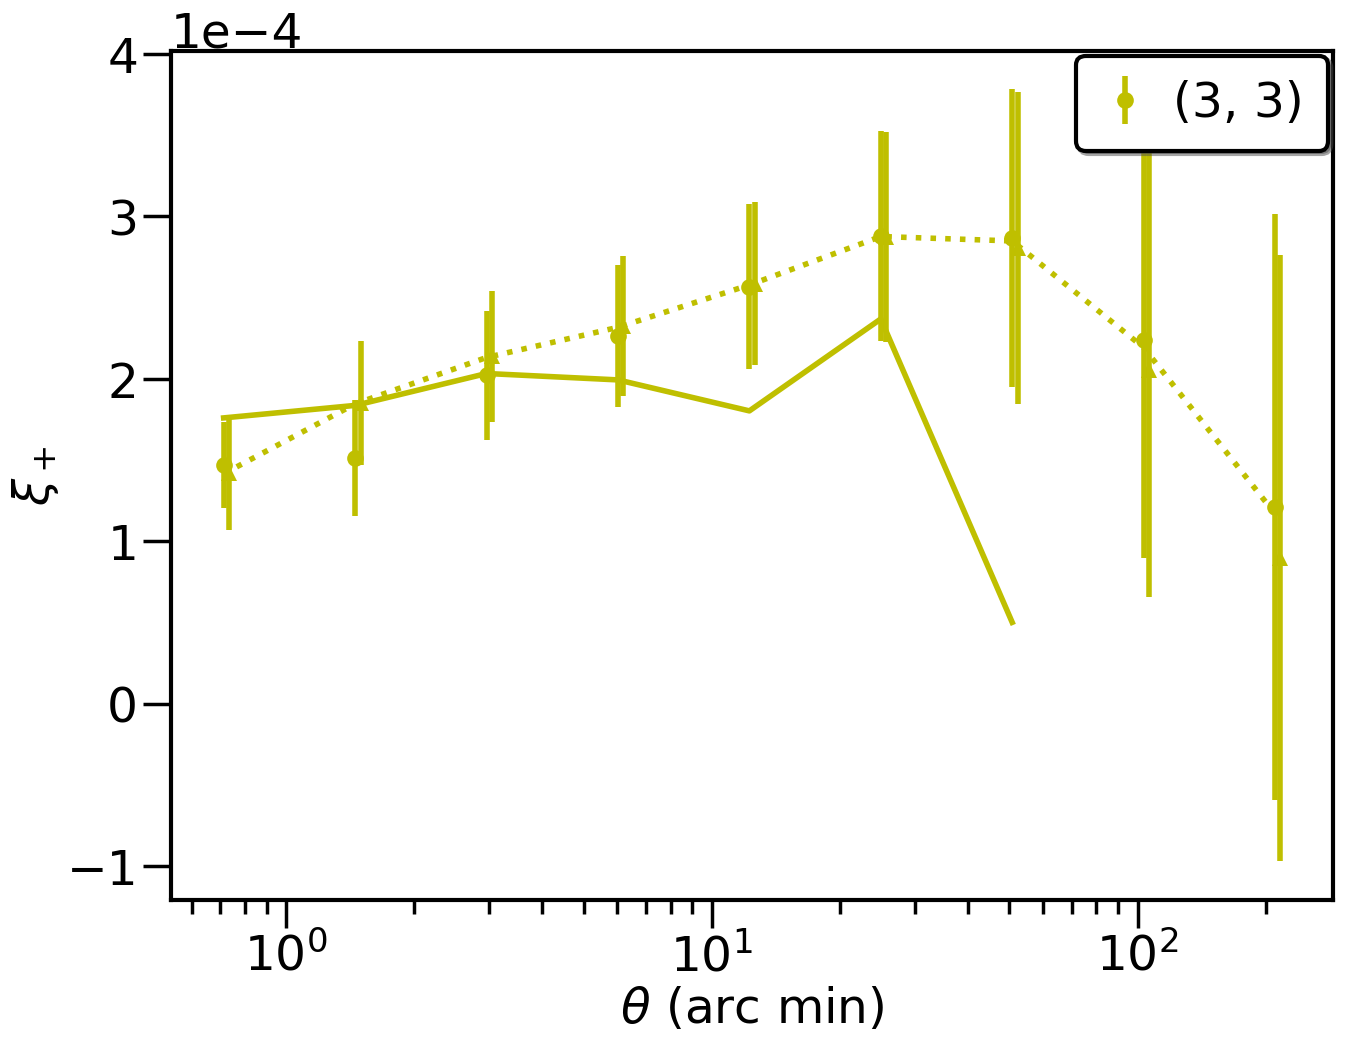

In [185]:
m1m2=(2,2)
cp=['r','b','g','y']#sns.color_pallete()
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb*60,thb*60*xiHG['xi'][corr][m1m2][(i,j)].compute(),
                 thb*60*np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j),color=cp[j])
        errorbar(thb*60*1.03,thb*60*xiWG_L['xi'][corr][m1m2][(i,j)].compute(),
                 thb*60*np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='^',color=cp[j])
        x=Kids_dat['pm']==1
        x*=Kids_dat['itomo']==i+1
        x*=Kids_dat['jtomo']==j+1
        th_t=Kids_dat['thetai'][x]
        plot(th_t,th_t*Kids_dat['xipmi'][x],color=cp[j])
        
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
        xi_plus = ccl.correlation(ccl_cosmo, XI_W_L.l, cls, XI_W_L.HT.theta[m1m2]/d2r,corr_type='L+', method='FFTLog')
        xi_b=XI_W_L.binning.bin_1d(xi=xi_plus,bin_utils=XI_W_L.xi_bin_utils[m1m2])
        plot(thb*60,thb*60*xi_b,color=cp[j],ls=':')
        
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


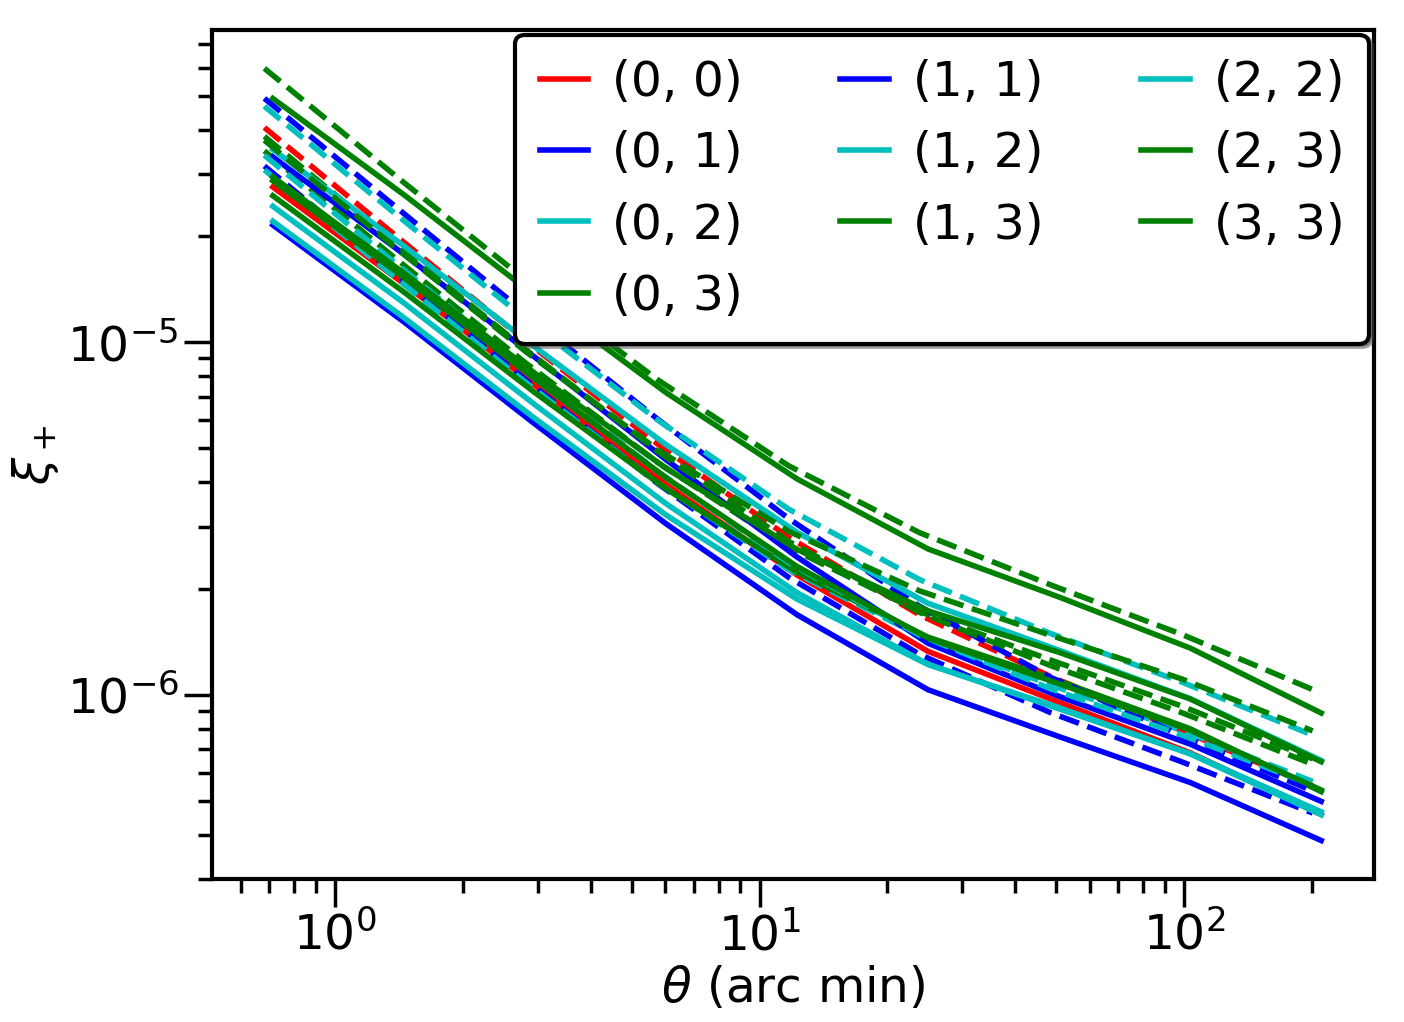

In [166]:
m1m2=(2,2)
i2=0
cs=['r','b','c','g','y']
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        x=Kids_cov['z1_i']==i+1
        x*=Kids_cov['z1_j']==j+1
        x*=Kids_cov['z2_i']==i+1
        x*=Kids_cov['z2_j']==j+1
        x*=Kids_cov['s1']==0
        x*=Kids_cov['s2']==0
        cov_t=Kids_cov[x]
        x=cov_t['th1']==cov_t['th2']
        cov_t=cov_t[x]['G']
        plot(thb*60,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j),
            c=cs[(i2+j2)%len(cs)])

        plot(thb/d2r,np.sqrt(cov_t),c=cs[(i2+j2)%len(cs)],ls='--')
        j2+=1
    i2+=1
xscale('log')
yscale('log')
xlabel(r'$\theta$ (arc min)')
ylabel(r'$\xi_+$')
legend(ncol=3)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


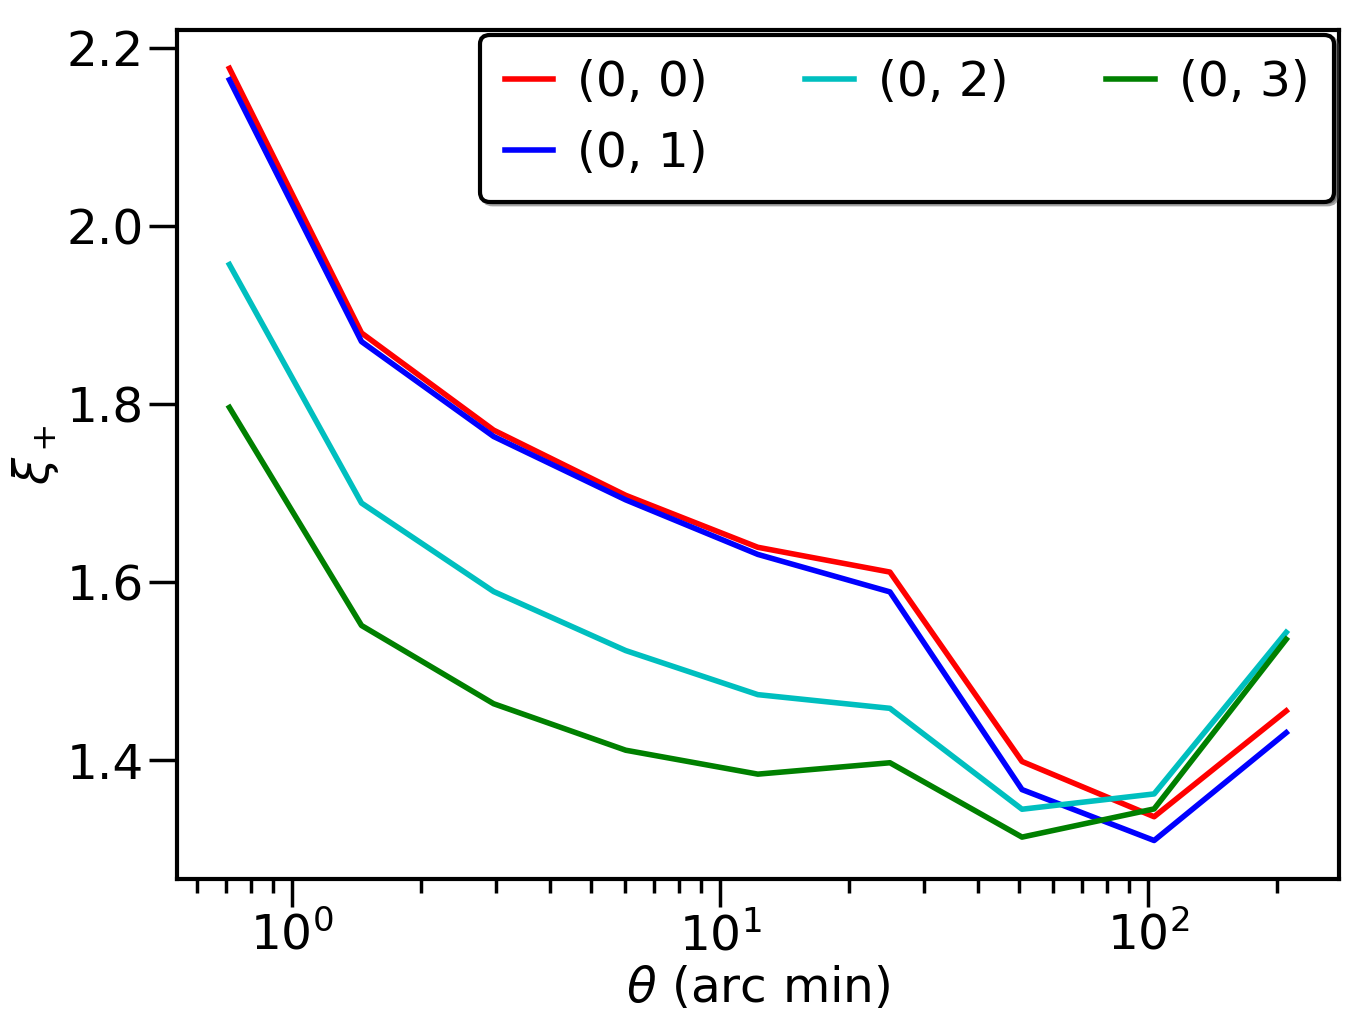

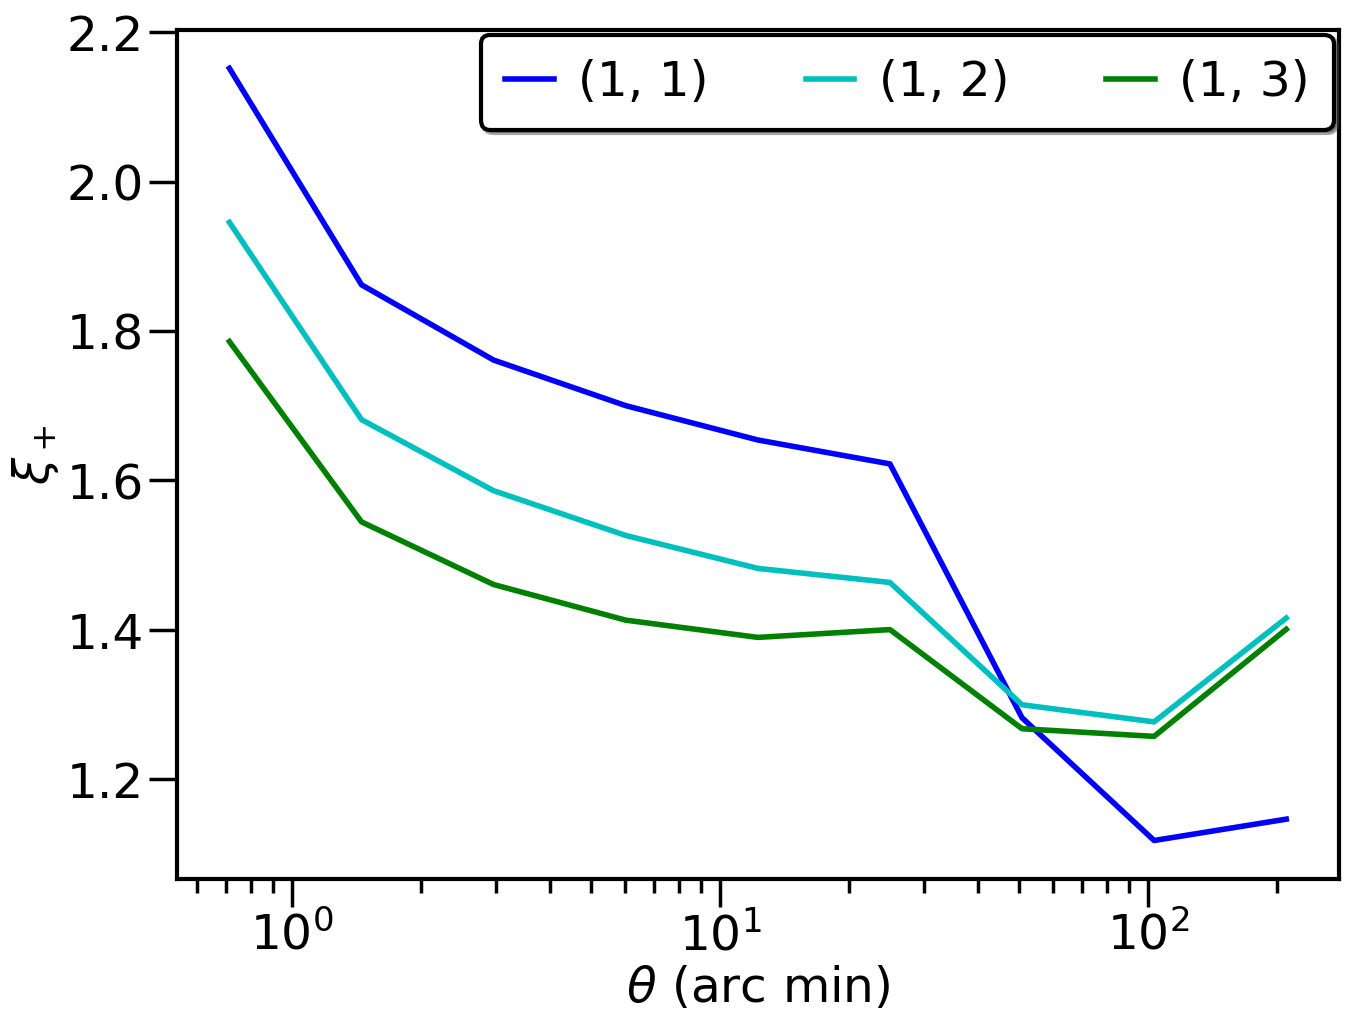

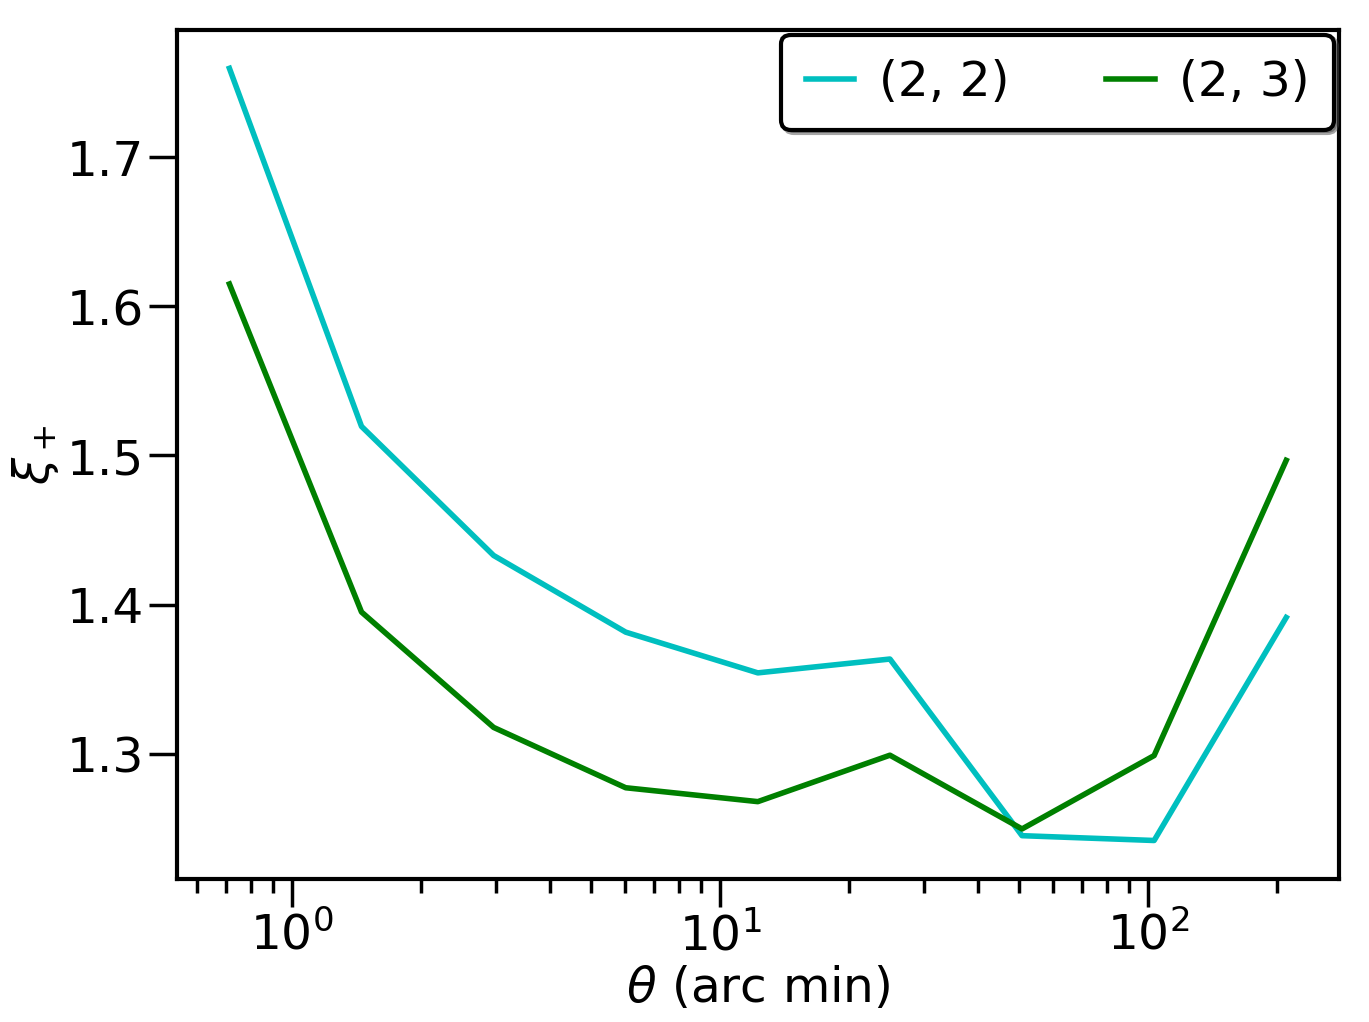

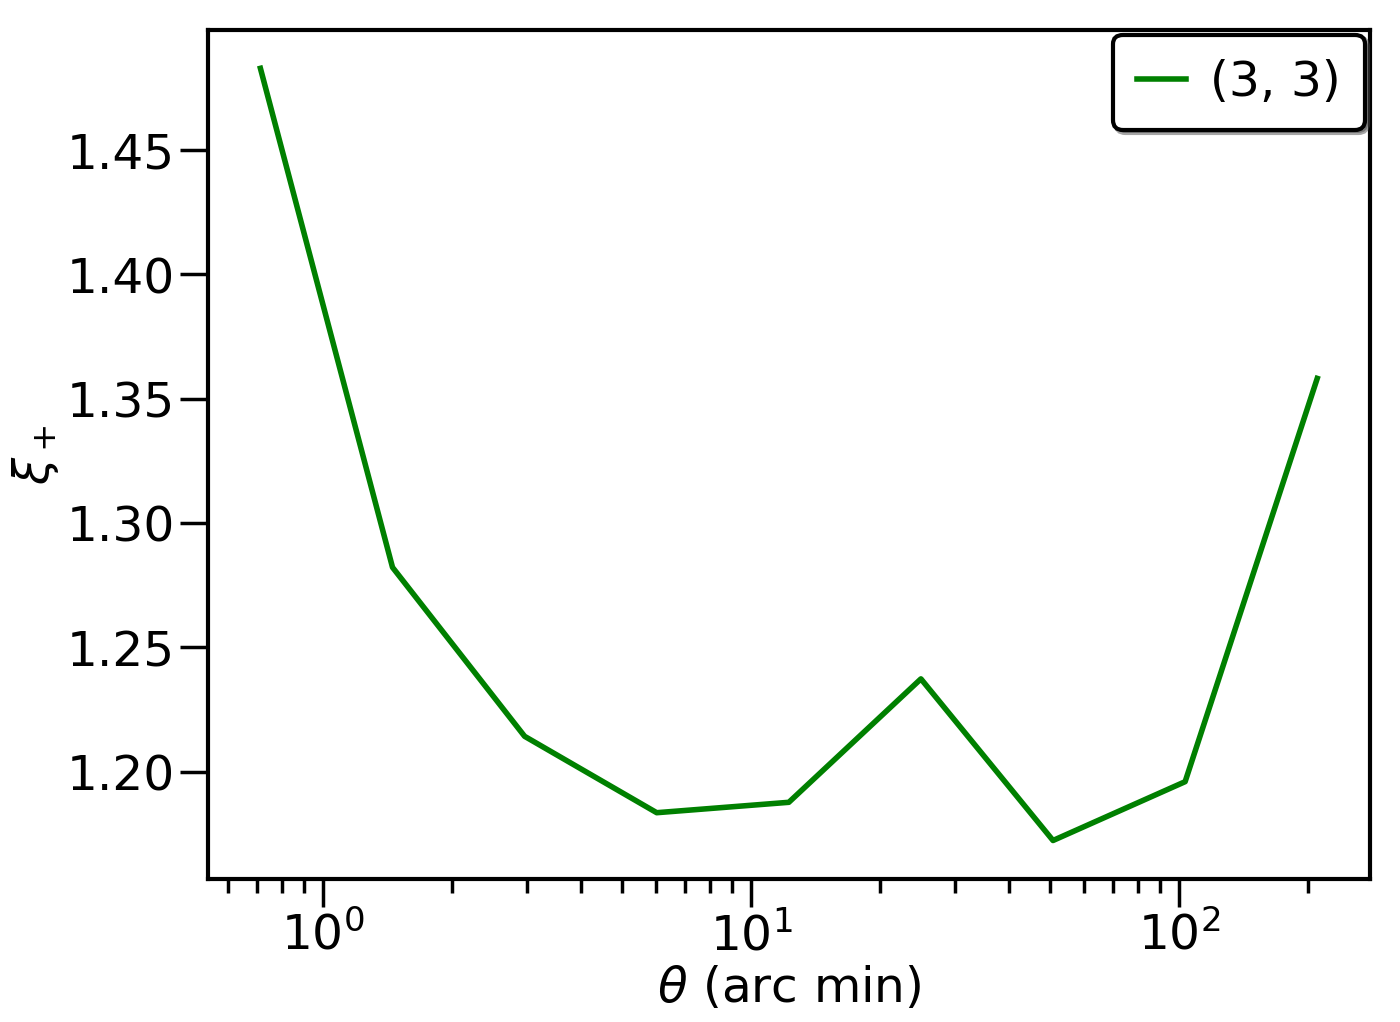

In [167]:
m1m2=(2,2)
nth=20
i2=0
cs=['r','b','c','g','y']
th=np.unique(Kids_cov['th1'])
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        x=Kids_cov['z1_i']==i+1
        x*=Kids_cov['z1_j']==j+1
        x*=Kids_cov['z2_i']==i+1
        x*=Kids_cov['z2_j']==j+1
        x*=Kids_cov['s1']==0
        x*=Kids_cov['s2']==0
        cov_t=Kids_cov[x]
        x=cov_t['th1']==cov_t['th2']
        cov_t=cov_t[x]['G']
        R=cov_t/np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])
#         R/=xiWG_L['xi'][corr][m1m2][(i,j)].compute()**2
        plot(thb*60,R,
             label=(i,j),c=cs[(i2+j2)%len(cs)])
        
        j2+=1
    i2+=1
    
    xscale('log')
#     yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


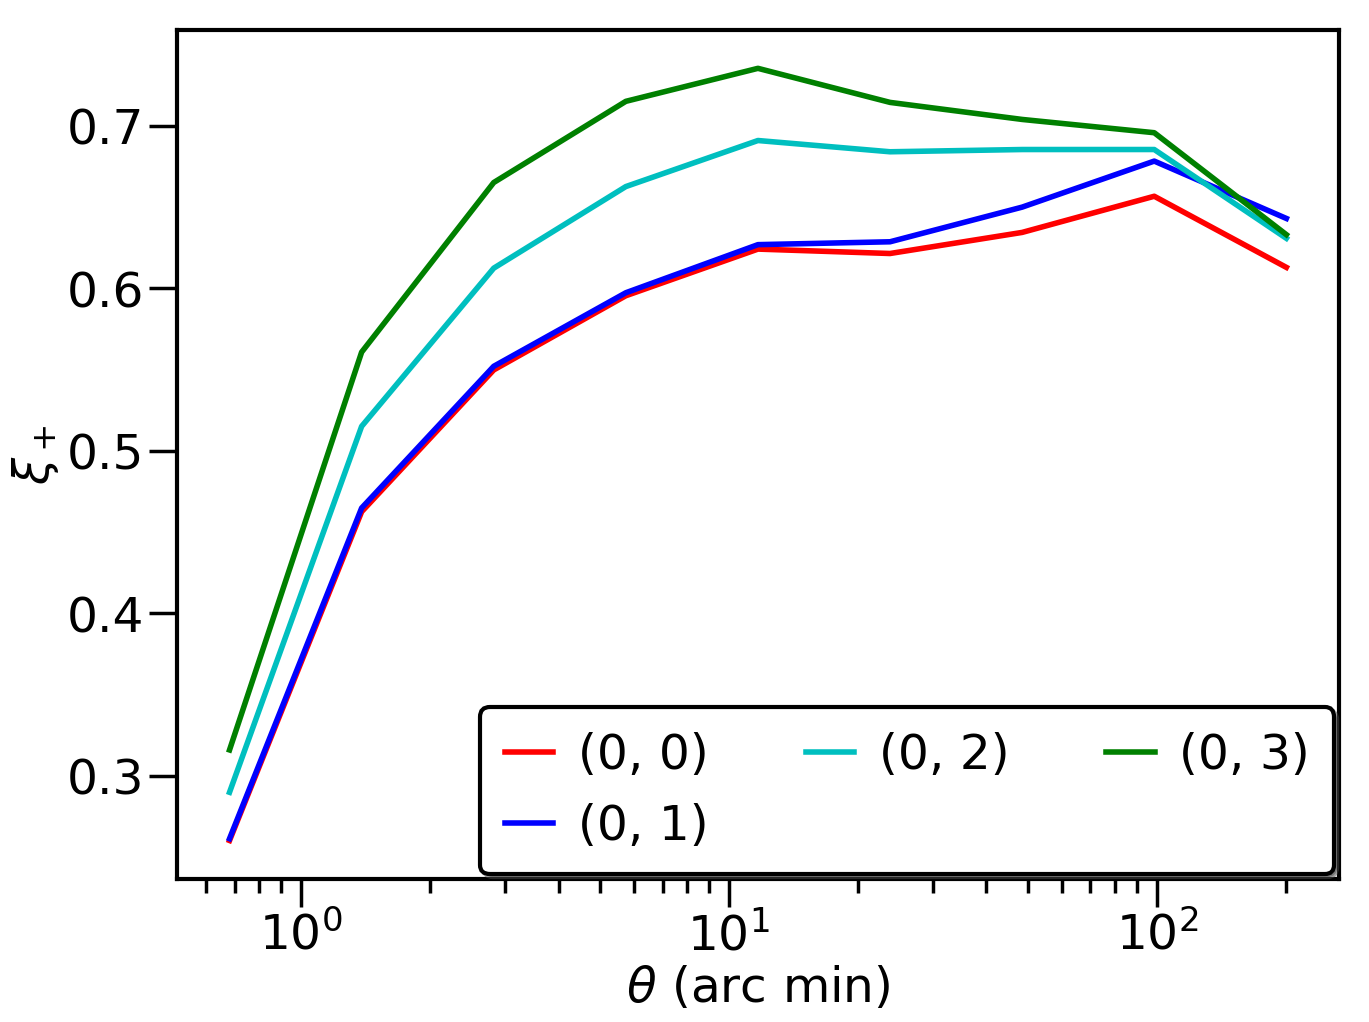

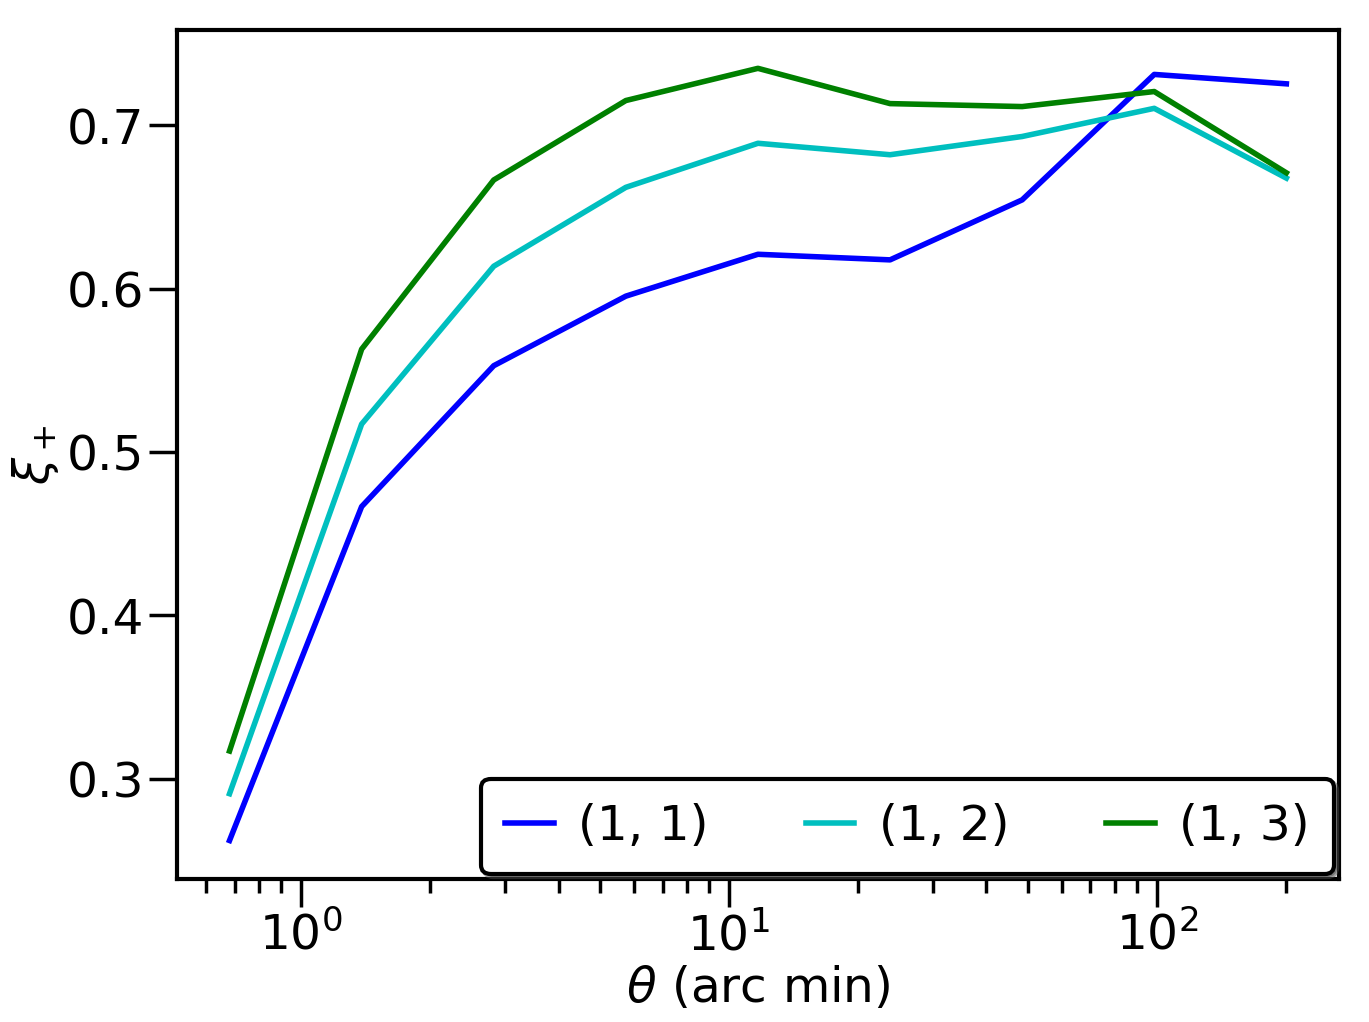

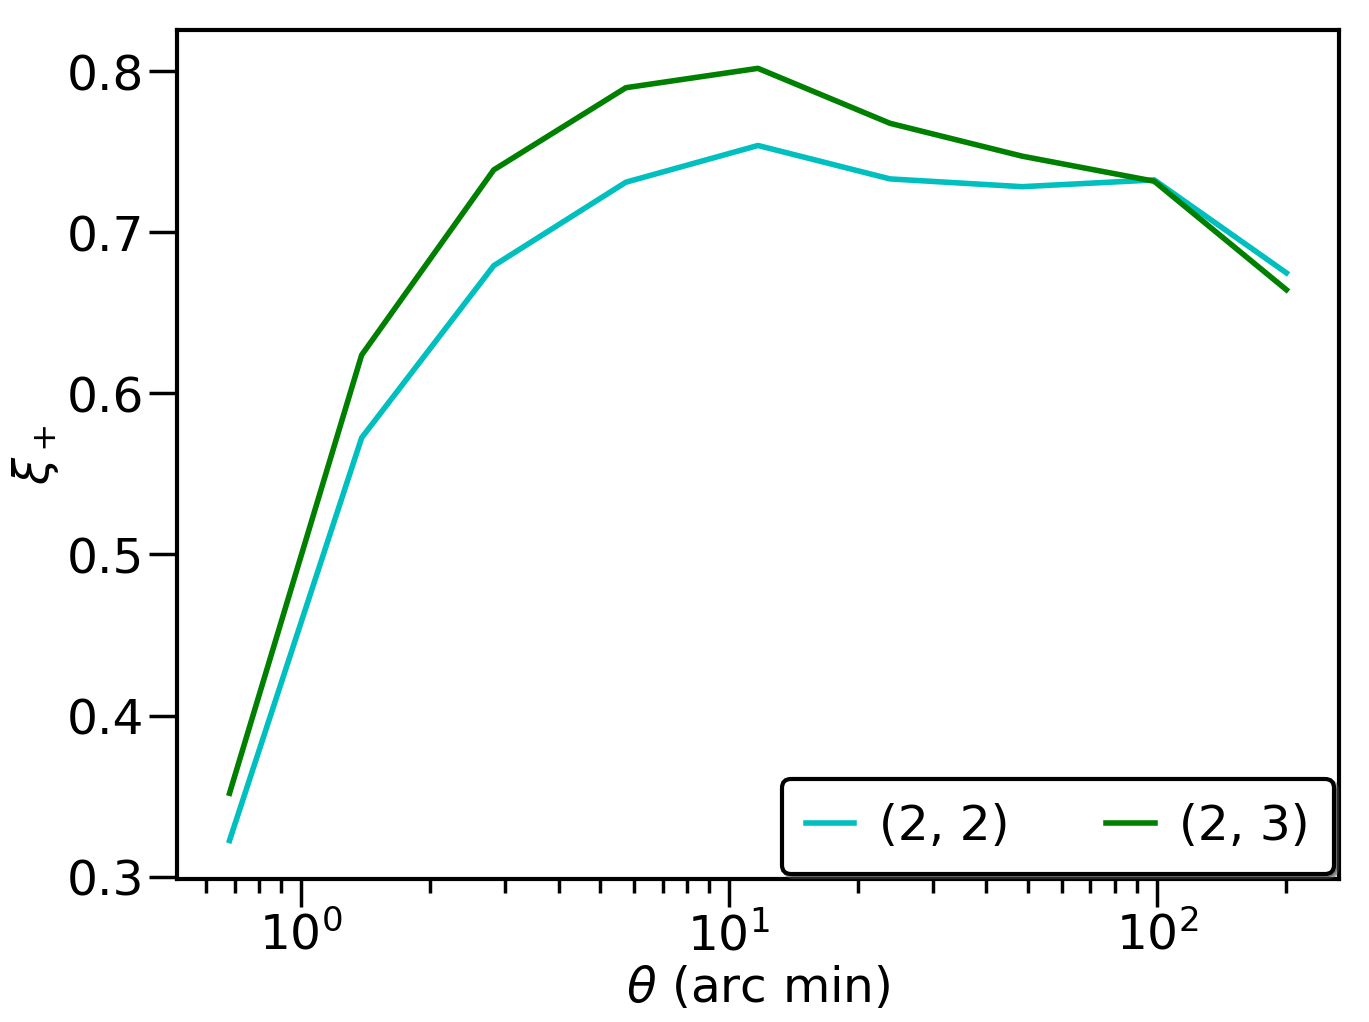

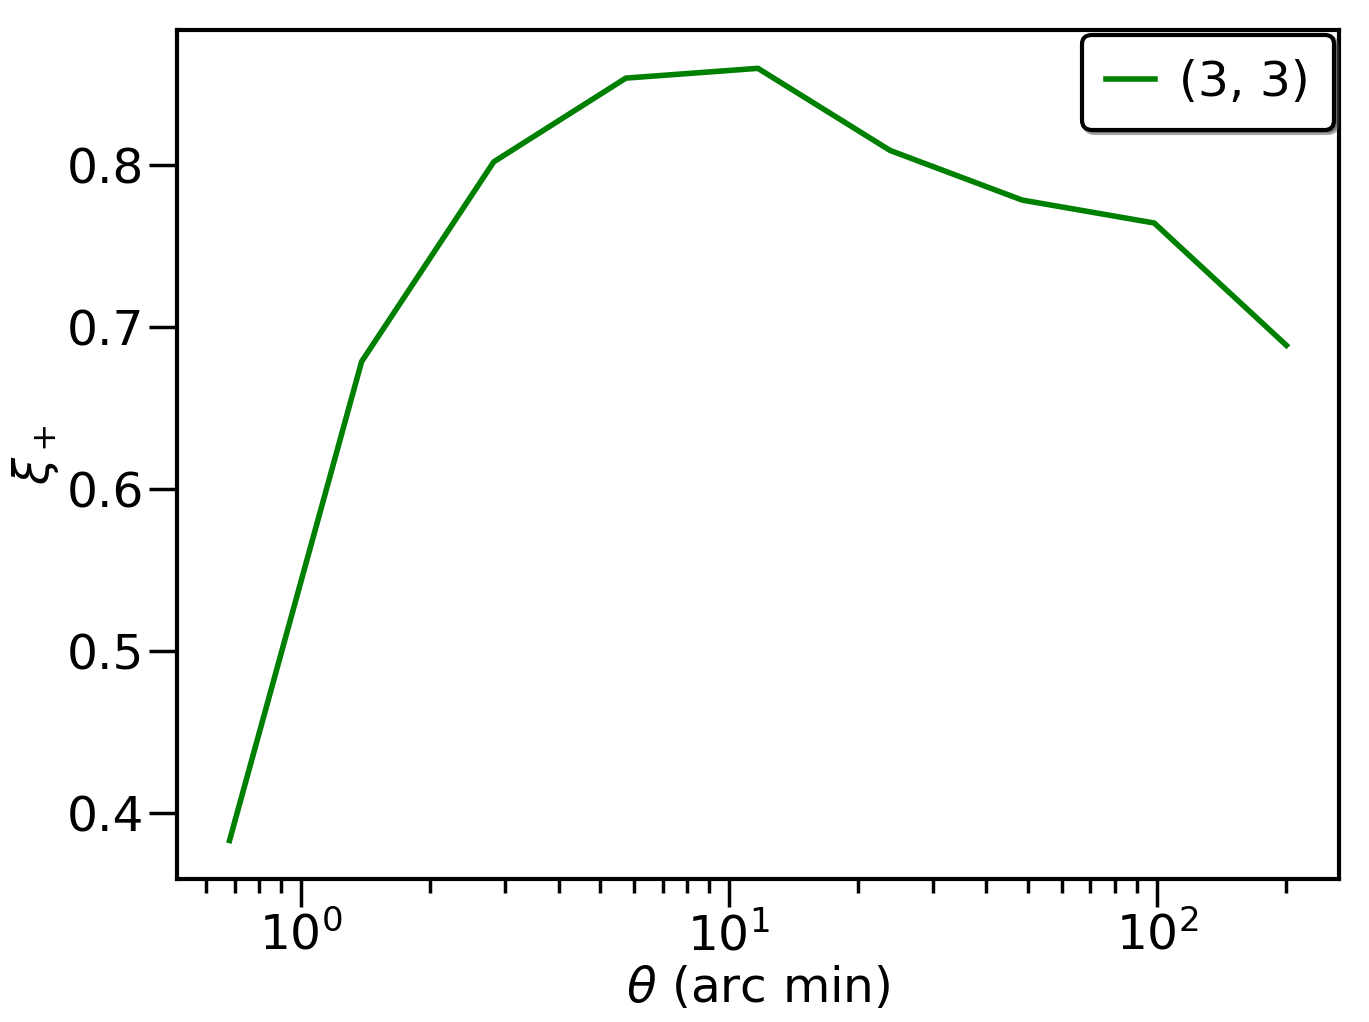

In [168]:
m1m2=(2,2)
nth=9
i2=0
cs=['r','b','c','g','y']
th=np.unique(Kids_cov['th1'])
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        x=Kids_cov['z1_i']==i+1
        x*=Kids_cov['z1_j']==j+1
        x*=Kids_cov['z2_i']==i+1
        x*=Kids_cov['z2_j']==j+1
        x*=Kids_cov['s1']==0
        x*=Kids_cov['s2']==0
        cov_t=Kids_cov[x]
        x=cov_t['th1']==cov_t['th2']
        cov_t=cov_t[x]['G']
        plot(thb/d2r,np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])/cov_t,
             label=(i,j),c=cs[(i2+j2)%len(cs)])
        j2+=1
    i2+=1
    
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


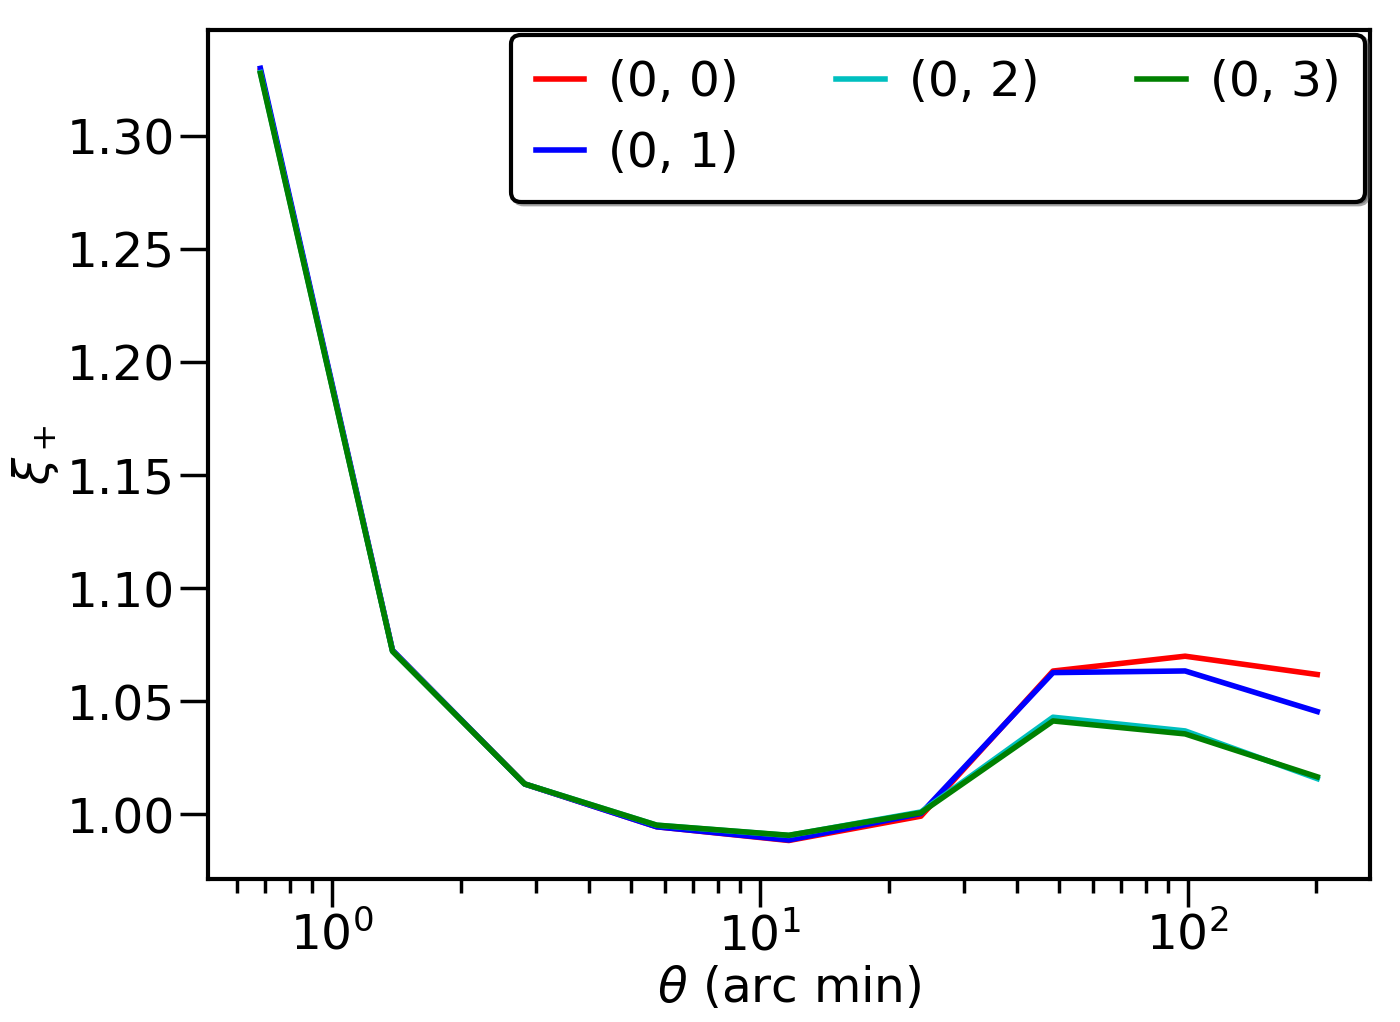

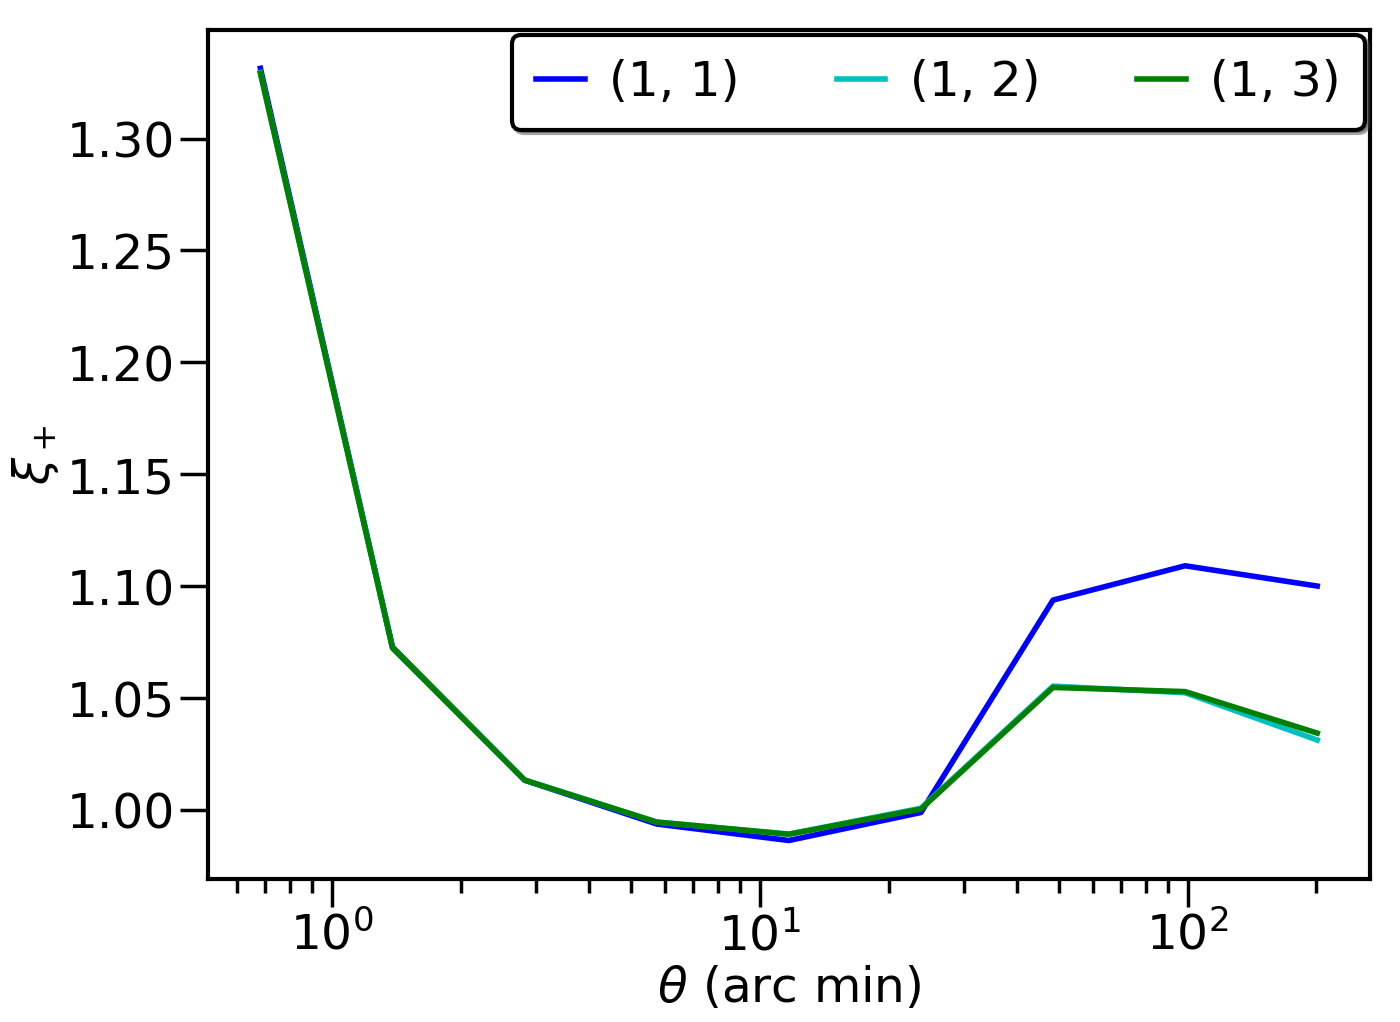

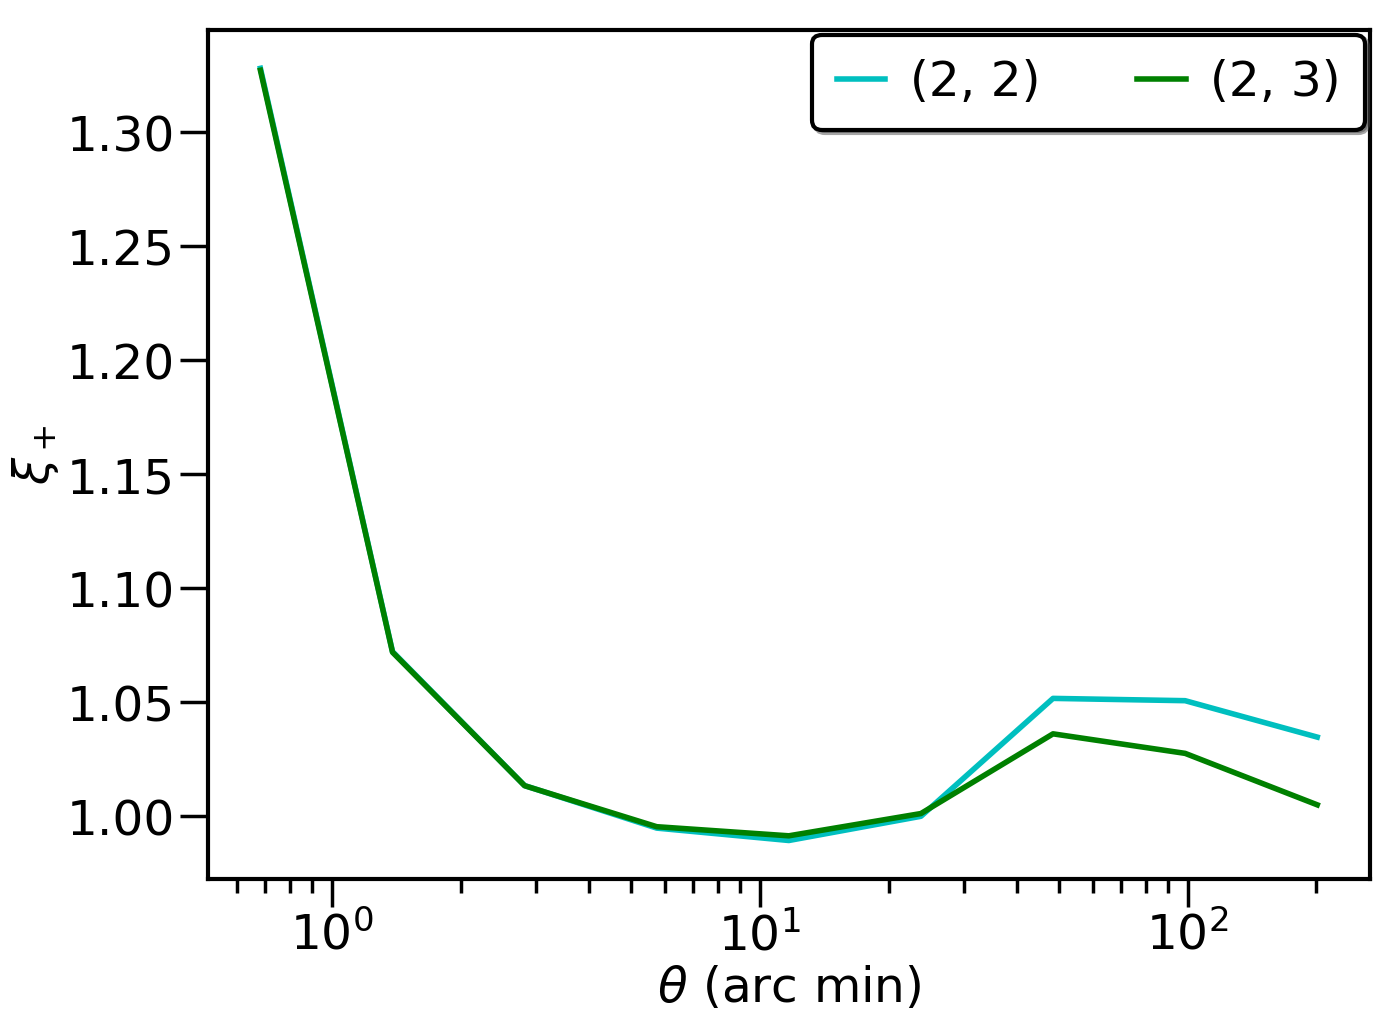

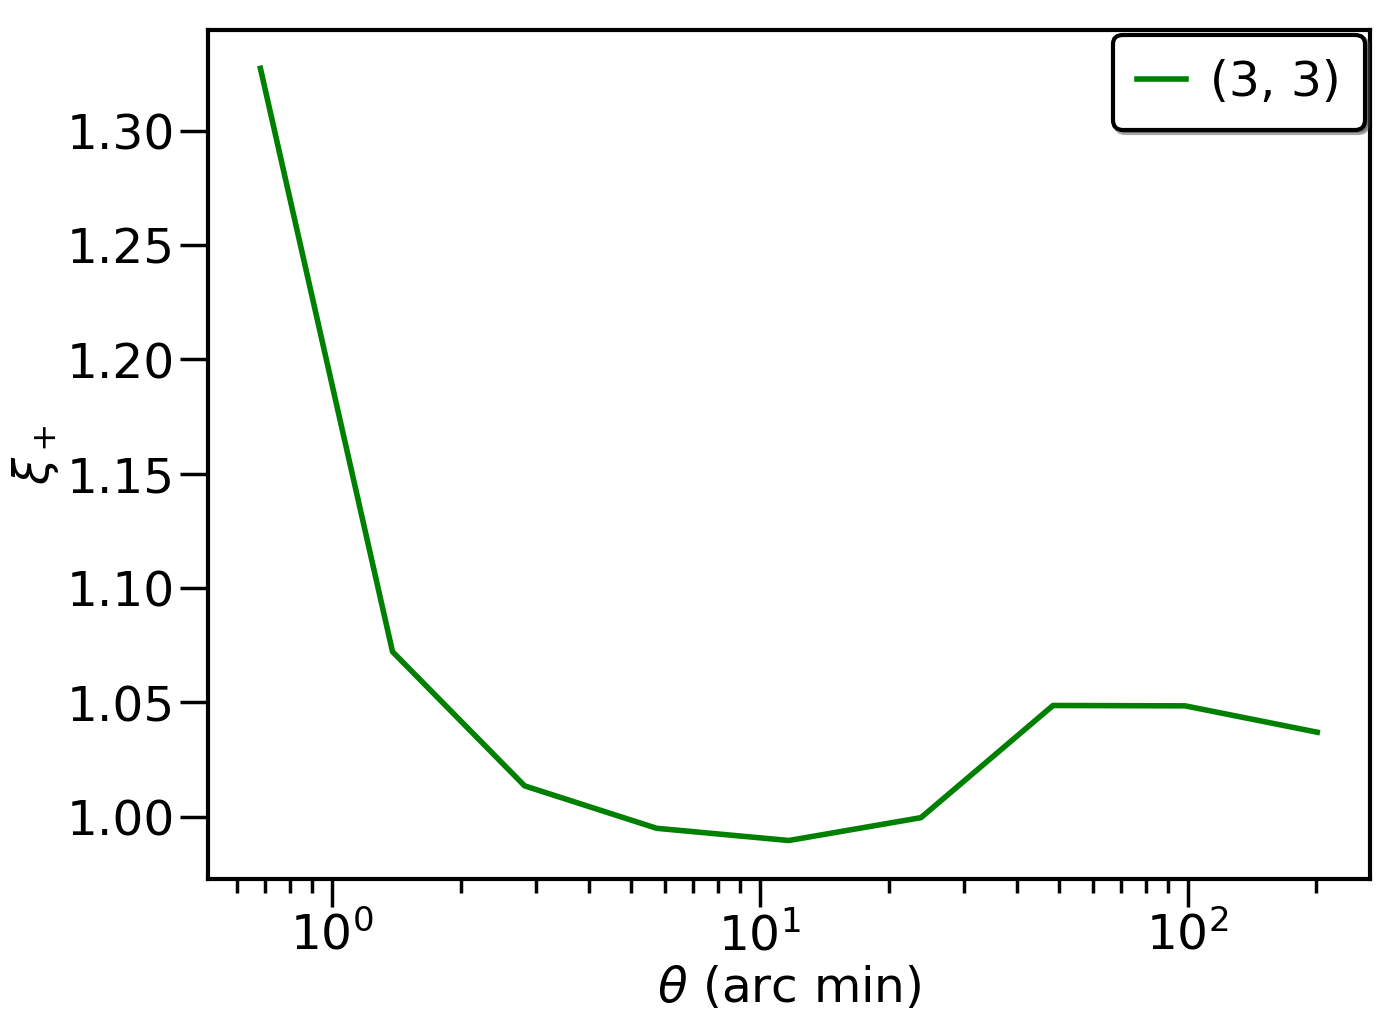

In [118]:
m1m2=(2,2)
nth=20
i2=0
cs=['r','b','c','g','y']
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        plot(thb/d2r,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),
             label=(i,j),c=cs[(i2+j2)%len(cs)])
        
        j2+=1
    i2+=1
    
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

In [119]:
crash

NameError: name 'crash' is not defined

# Galaxy X Lensing Correlation function covariance

In [ ]:
import galaxy_utils
reload(galaxy_utils)
from galaxy_utils import *

In [ ]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [ ]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [ ]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=5  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
# nbins=3  # Number of tomographic bins
z_sigma=0.1
zg_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))


# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

SSV_cov=True
tidal_SSV=False

In [ ]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=1./60
th_max=10
n_th_bins=20
n_th=160
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th)
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [ ]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [ ]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
WT_kwargs={'l':l_W ,'theta':th*d2r ,'m1_m2':[(0,0),(0,2),(2,2),(2,-2)]}
# %time WTggl=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zg_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,HT=WTggl,
#               HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [ ]:
%time cl_Wggl=XI_W.cl_tomo(corrs=[corr_ll,corr_ggl,corr_gg])

In [ ]:
%time xiWggl=XI_W.xi_tomo(corrs=[corr_ll,corr_ggl,corr_gg])
%time xiW_ggl=xiWggl['stack'].compute()

In [ ]:
cl_Wggl['cl'][corr_ggl][(0,0)].compute().min()

In [ ]:
cl_Wggl['cl'].keys()

In [ ]:
cl_Wggl['cov'][corr_ggl+corr_ggl][(0,0,0,1)]['G1423'].compute().min()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),label=(i,j))
        plot(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),ls='--')
        xscale('log')
        yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(0,nbins):
        errorbar(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
nbins=5

In [ ]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW_ggl['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
x1=20.*nbins*(nbins+1)/2.
x2=20.*nbins*nbins
hlines(x1,0,len(corrW),lw=2)
vlines(x1,0,len(corrW),lw=2)
hlines(x1*2,0,len(corrW),lw=2)
vlines(x1*2,0,len(corrW),lw=2)
hlines(x1*2+x2,0,len(corrW),lw=2)
vlines(x1*2+x2,0,len(corrW),lw=2)
title('Wigner')
xticks([])
yticks([])
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
import healpy as hp
hp.nside2npix(1024)